In [2]:
!pip install gym

Homework 3 submission for Nirja Oak (ID: 964236111) and Anushka Deshpande (ID: 934381971)


##The T-maze environment

The TMazeEnv1 environment represents a T-shaped maze where an agent (represented as a mouse) can navigate. Here's a description of the maze environment:

The maze is represented as a 15x15 grid, with walls and open spaces.
The mouse (agent) is initially placed at a specific location within the maze (specified as (mouse_row, mouse_col)).


The mouse can take actions to move in different directions: straight, left, or right. These actions are represented as 0, 1, and 2, respectively.


The goal of the mouse is to reach either the leftmost cell in the second row ((1, 0)) or the rightmost cell in the second row ((1, 14)). These cells act as final reward locations.


The mouse receives rewards based on its current position and the presence of cues and the final reward locations.


Cues are randomly placed in the maze, either on the left side or the right side. The number of cues on each side is specified as n_cues_left and n_cues_right. The presence of cues affects the rewards obtained by the mouse.
If the number of cues on the left side is greater than the number of cues on the right side, the mouse receives a positive reward for cues on the left side and a negative reward for cues on the right side. If the number of cues on the right side is greater, the rewards are reversed.


The mouse can see the cues in the cells below its current position. If a cue is detected, the mouse receives the associated reward.


The maze is visualized using matplotlib, with the mouse, cues, and final reward locations displayed as different symbols on the grid.


Our hypothesis is that as the complexity of the task increases, that is the difference between number of cues on the left and right is decreased,the task would become harder.



In [3]:
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt
import random
class TMazeEnv1(gym.Env):
    def __init__(self,rat=(14,7)):
        self.grid = np.ones((15, 15), dtype=float)
        self.grid[:, :6] = 0
        self.grid[:, 9:] = 0
        self.grid[:3, :] = 1
        self.action_space = spaces.Discrete(3)  # 0: straight, 1: left, 2: right

        self.observation_space = spaces.Discrete(3)  # 0: no cue, 1: cue on the left, 2: cue on the right
        #episode done flag
        self.done=False
        self.current_state = ()
        self.previous_state=()#to reestore the previous state in the render
        self.valid_actions=[]#contains all possible valid actions
        self.reward_loc = None#to assign a cell in the grid to be the reward location
        self.cue_loc_r=[]#to assign grid in the cell to be cue location
        self.cue_loc_l=[]
        #no of cues on the right or left
        self.n_cues_right=0
        self.n_cues_left=0
        #assign cue and final reward values
        self.cue_reward_l=0
        self.cue_reward_r=0
        self.final_reward=5
        self.total_reward=0
        self.reward_flag=False
        #observation corridor and obervation reward
        self.obs_corridor_r=None
        self.obs_corridor_l=None
        self.obs_reward=None
        #valid actions aat decision point
        self.valid_action_decision=[]
        self.free_cells = [(r, 7) for r in range(1, 15)] + [(1, c) for c in range(15)]
        if not rat in self.free_cells:
            raise Exception("Invalid Rat Location: must sit on a free cell")

        self.reset(rat,self.n_cues_left,self.n_cues_right)
    def valid_actions(self):
        rat_row, rat_col = self.current_state
        self.valid_action_corridor=0
        self.valid_action_decision=[1,2]
        self.valid_action_left=1
        self.valid_action_right=2



        return self.valid_actions
    def get_state_matrix(self):
        state_matrix = np.copy(self.grid[3:15, 7])
        return state_matrix

    def reset(self,rat,n_cues_right,n_cues_left):

            self.rat = rat
            self.grid = np.ones((15, 15), dtype=float)
            self.grid[:, :6] = 0
            self.grid[:, 9:] = 0
            self.grid[:3, :] = 1
            #reset rewards


            self.total_reward=0
            self.reward_flag=False

            nrows, ncols = self.grid.shape
            row, col = rat
            self.current_state = (row, col)
            self.previous_state=(0,0)
            self.n_cues_right = n_cues_right
            self.n_cues_left = n_cues_left
            self.cue_loc_r = []
            self.cue_loc_l = []
            #if the no of cues is greater on the left than right then thats where the ultimate reward is
            if  self.n_cues_left>self.n_cues_right:
                self.reward_loc=[1,0]
               #cues on the left are assigned a positive reward
                self.cue_reward_l=1
                self.cue_reward_r=-1
            else:
                self.reward_loc=[1,14]
                #cues on the right are assigned a positive reward
                self.cue_reward_l=-1
                self.cue_reward_r=+1
            self.valid_cells_rows_l = random.sample(range(3, 15), self.n_cues_left)
            self.cue_loc_l= [(r, 6) for r in self.valid_cells_rows_l]
            self.valid_cells_rows_r = random.sample(range(3, 15), self.n_cues_right)
            self.cue_loc_r= [(r, 8) for r in self.valid_cells_rows_r]






    def get_reward(self):
        rat_row, rat_col = self.current_state
        self.total_reward = 0
        if rat_row>=2 and rat_row<15:#if rat is in corridor
         for i in range(len(self.cue_loc_l)):#go over the list of cue locations on left and add rewrad
              cue_l_row,cue_l_col=self.cue_loc_l[i]
              if cue_l_row-rat_row == 1:#sees reward to the left
                self.total_reward+=self.cue_reward_l

         for i in range(len(self.cue_loc_r)):#go over the list of cue locations on left and add rewrad
              cue_r_row,cue_r_col=self.cue_loc_r[i]
              if cue_r_row-rat_row == 1:#sees reward to the right
                self.total_reward+=self.cue_reward_r

        if rat_row == 1 and rat_col == 0:
            self.total_reward += self.final_reward
            self.reward_flag=True
        elif rat_row == 1 and rat_col == 14:
            self.total_reward += self.final_reward
            self.reward_flag=True
        return self.total_reward


    def step(self, action):
        row, col = self.current_state
        row_prev=0
        col_prev=0
        if row==2 and col==7:
              row_prev=2
              col_prev=7



              if action==1:

                col-=1
                row-=1


              if action==2:

                col+=1
                row-=1

              if action==0:
                print("invalid action")



        elif row==1 and 0<col<=7:

            col-=1
            col_prev=col+1
            row_prev=1

        elif row==1 and 7<=col<15:

            col+=1
            col_prev=col-1
            row_prev=1

        elif col==7 and 1<=row<=14:

            row -= 1
            row_prev=row+1
            col_prev=7


        self.previous_state=(row_prev,col_prev)
        self.current_state = (row, col)
        self.done = False
        reward = self.get_reward()

        if self.current_state==(1,0) or   self.current_state==(1,14):
            self.done = True

        return self.grid, self.current_state[0], self.current_state[1], reward, self.done  #return observation, reward, done, {}




    def render(self, mode='human'):

        row, col = self.current_state
        row_prev,col_prev=self.previous_state
        self.grid[row,col]=0#rat
        self.grid[row_prev,col_prev]=1
        row_reward,column_reward=self.reward_loc
        self.grid[row_reward,column_reward]=0.3#reward cell
        for i in range(len(self.cue_loc_l)):#go over the list of cue locations on left and add rewrad
              cur_l_row,cue_l_col=self.cue_loc_l[i]
              self.grid[cur_l_row,cue_l_col]=0.7

        for i in range(len(self.cue_loc_r)):#go over the list of cue locations on left and add rewrad
              cur_r_row,cue_r_col=self.cue_loc_r[i]
              self.grid[cur_r_row,cue_r_col]=0.7


        plt.imshow(self.grid, cmap='gray')
        plt.axis('off')
        plt.savefig('maze_image.png')
        plt.show()





In [4]:
from gym.envs.registration import register


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
register(
    id='TMaze-v1',
    entry_point='tmaze_env:TMazeEnv1',  # Replace 'custom_env' with the name of the file containing the TMazeEnv class
)


Lets first initialize a random agent and render the environment

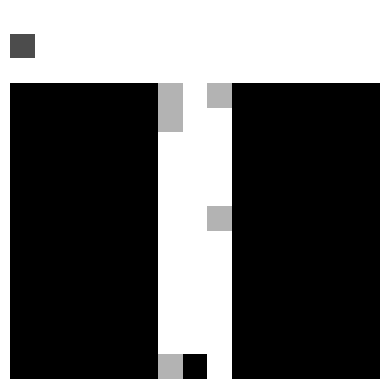

Row: 13 Col: 7 Reward: 1


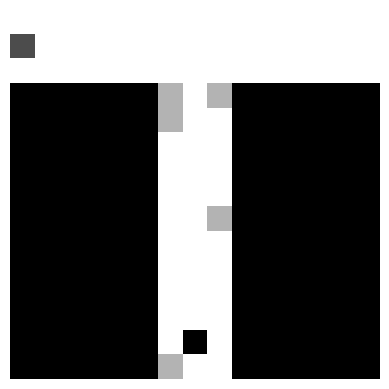

Row: 12 Col: 7 Reward: 0


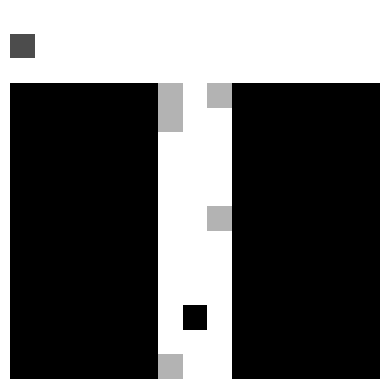

Row: 11 Col: 7 Reward: 0


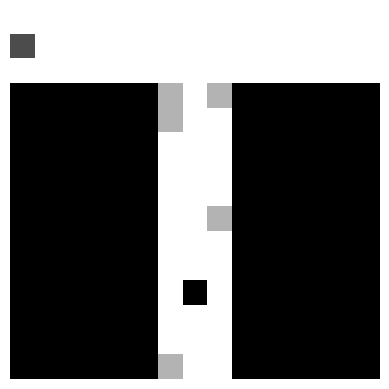

Row: 10 Col: 7 Reward: 0


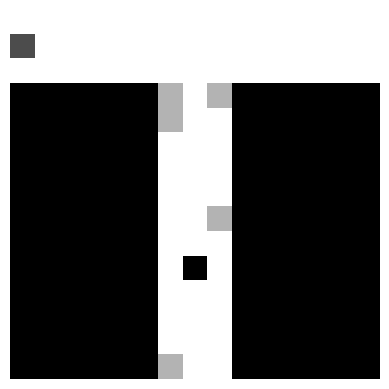

Row: 9 Col: 7 Reward: 0


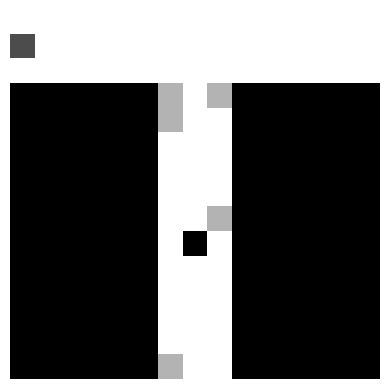

Row: 8 Col: 7 Reward: 0


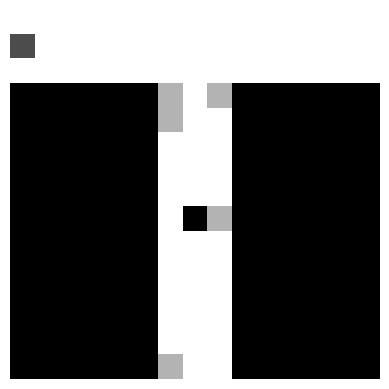

Row: 7 Col: 7 Reward: -1


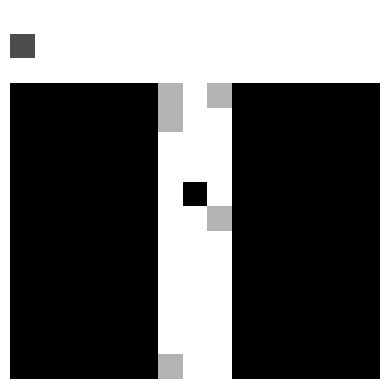

Row: 6 Col: 7 Reward: 0


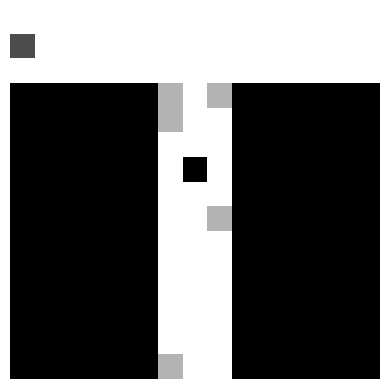

Row: 5 Col: 7 Reward: 0


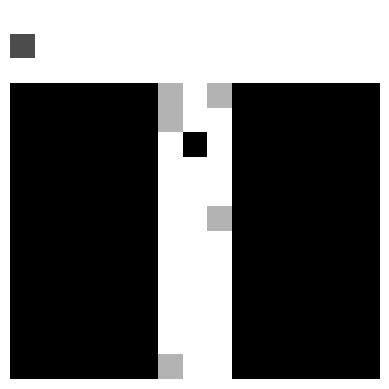

Row: 4 Col: 7 Reward: 0


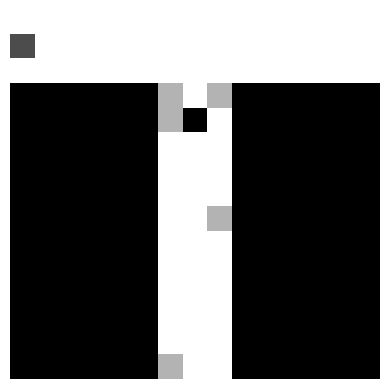

Row: 3 Col: 7 Reward: 1


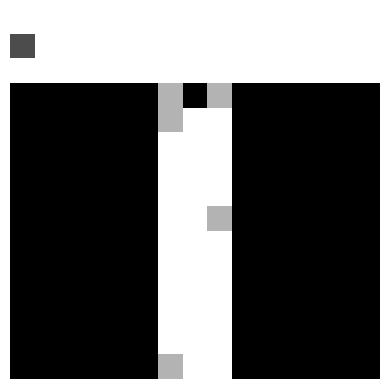

Row: 2 Col: 7 Reward: 0


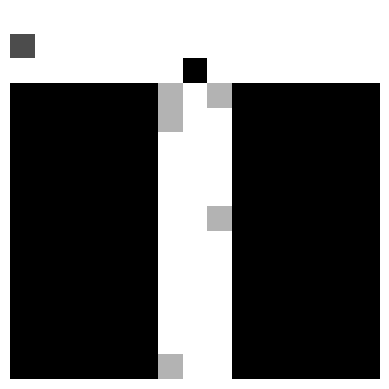

Taking decision
Action: 0
invalid action
Row: 2 Col: 7 Reward: 0


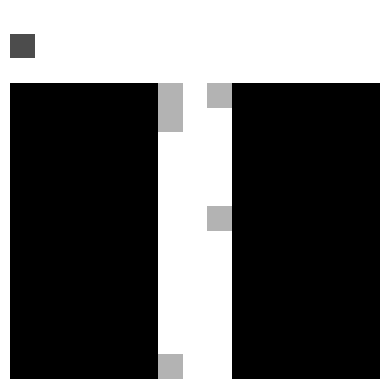

Taking decision
Action: 1
Row: 1 Col: 6 Reward: 0


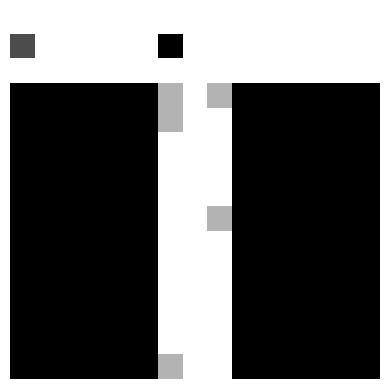

Row: 1 Col: 5 Reward: 0


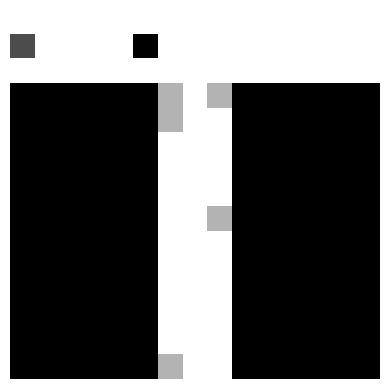

Row: 1 Col: 4 Reward: 0


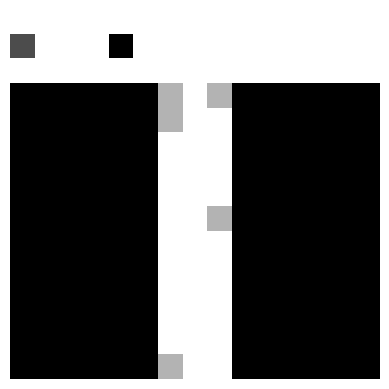

Row: 1 Col: 3 Reward: 0


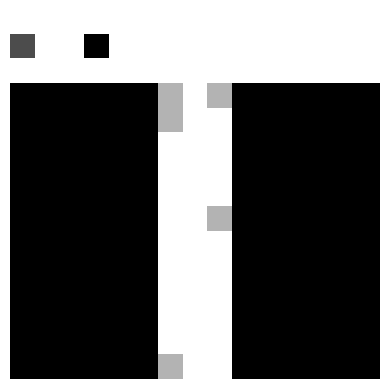

Row: 1 Col: 2 Reward: 0


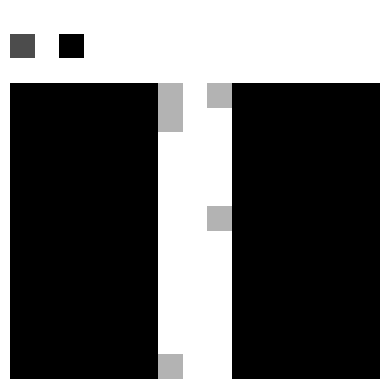

Row: 1 Col: 1 Reward: 0


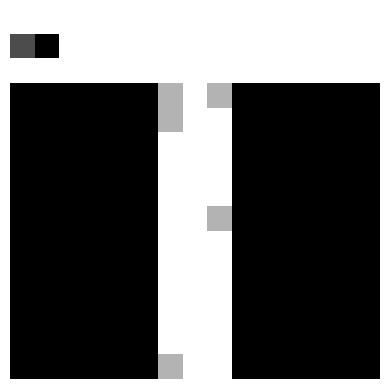

Row: 1 Col: 0 Reward: 5
Episode 1 completed.
Final Reward: 5


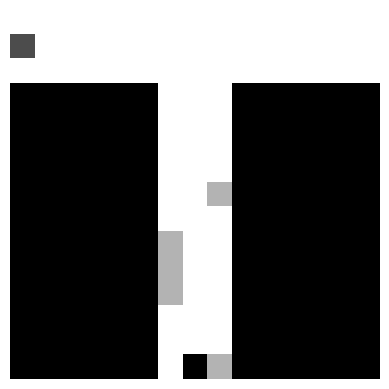

Row: 13 Col: 7 Reward: -1


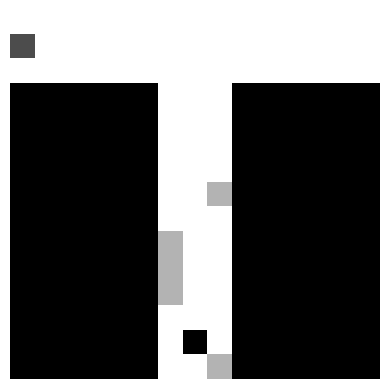

Row: 12 Col: 7 Reward: 0


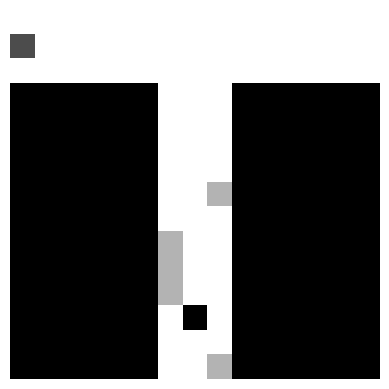

Row: 11 Col: 7 Reward: 0


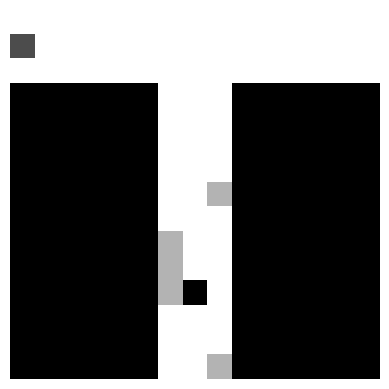

Row: 10 Col: 7 Reward: 1


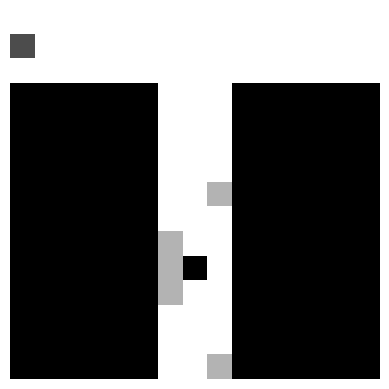

Row: 9 Col: 7 Reward: 1


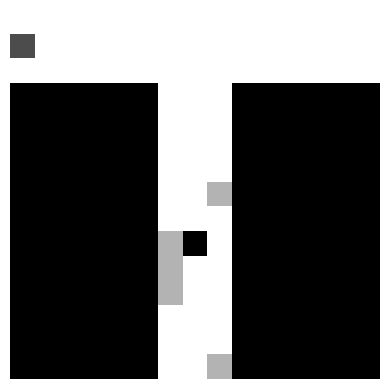

Row: 8 Col: 7 Reward: 1


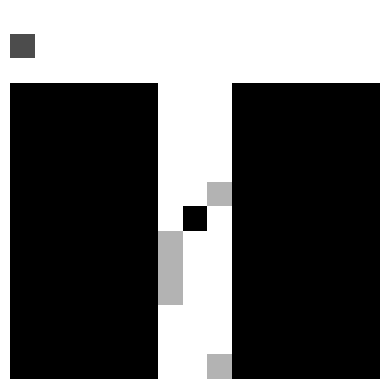

Row: 7 Col: 7 Reward: 0


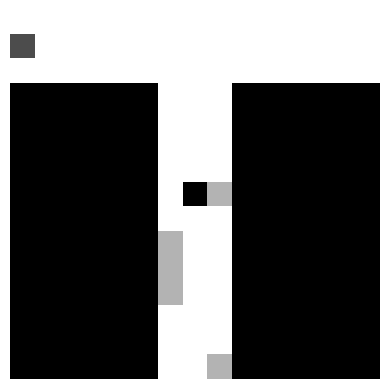

Row: 6 Col: 7 Reward: -1


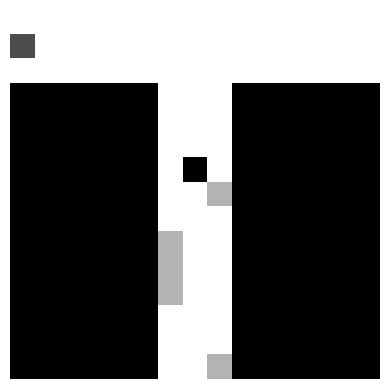

Row: 5 Col: 7 Reward: 0


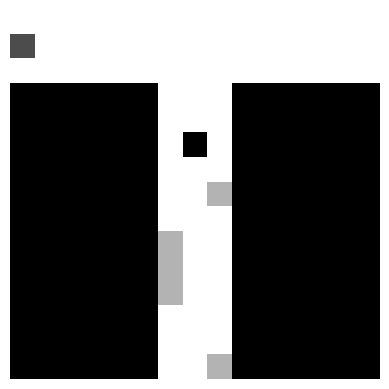

Row: 4 Col: 7 Reward: 0


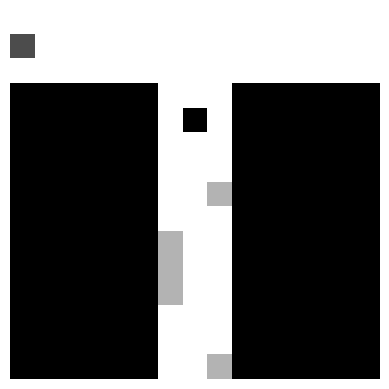

Row: 3 Col: 7 Reward: 0


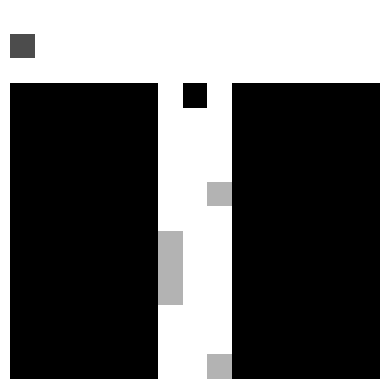

Row: 2 Col: 7 Reward: 0


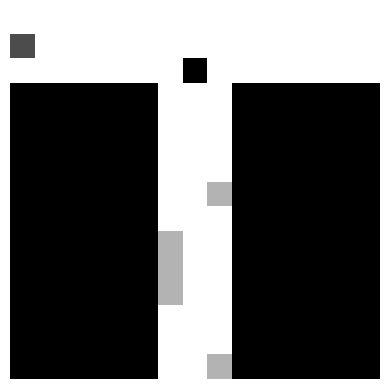

Taking decision
Action: 2
Row: 1 Col: 8 Reward: 0


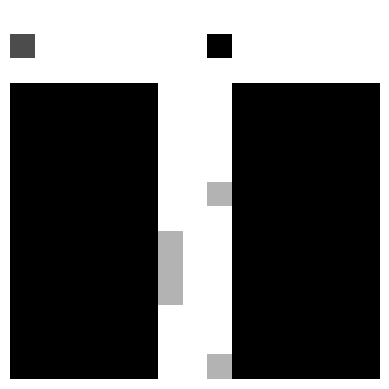

Row: 1 Col: 9 Reward: 0


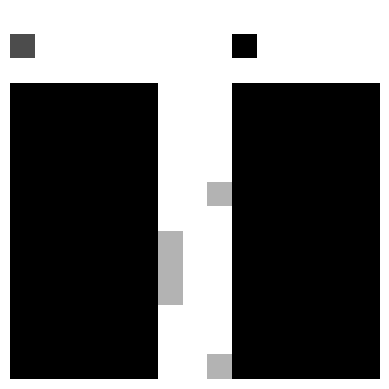

Row: 1 Col: 10 Reward: 0


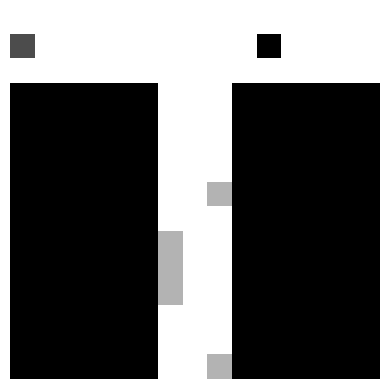

Row: 1 Col: 11 Reward: 0


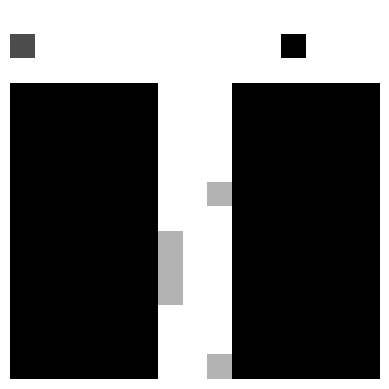

Row: 1 Col: 12 Reward: 0


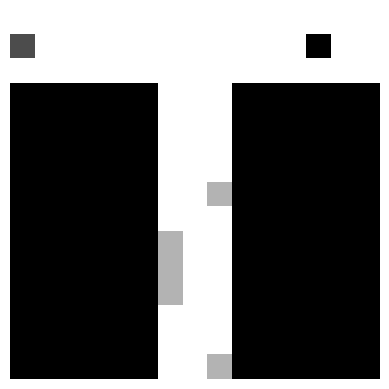

Row: 1 Col: 13 Reward: 0


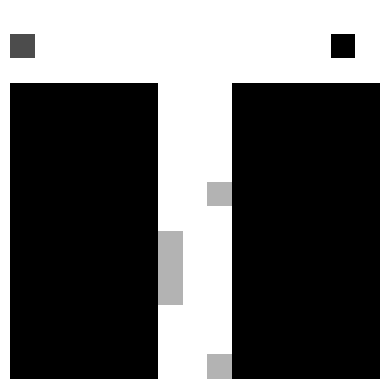

Row: 1 Col: 14 Reward: 5
Episode 2 completed.
Final Reward: 5


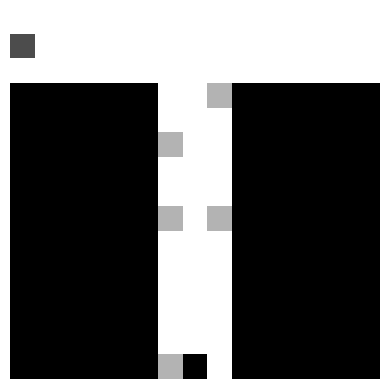

Row: 13 Col: 7 Reward: 1


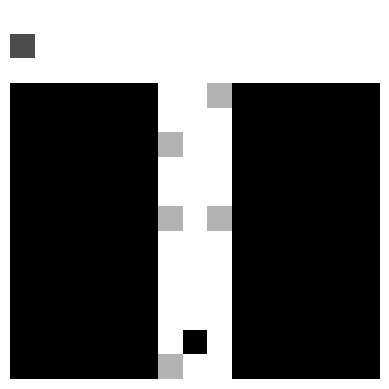

Row: 12 Col: 7 Reward: 0


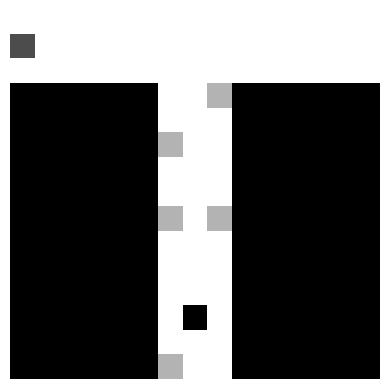

Row: 11 Col: 7 Reward: 0


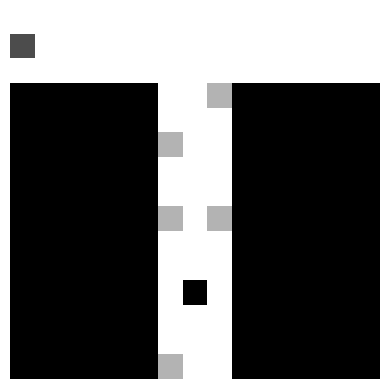

Row: 10 Col: 7 Reward: 0


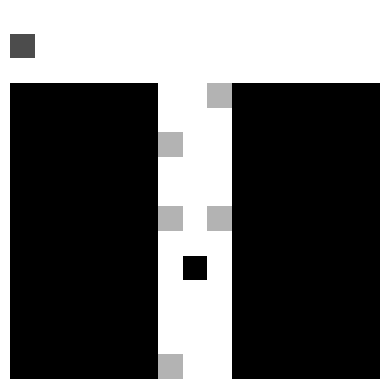

Row: 9 Col: 7 Reward: 0


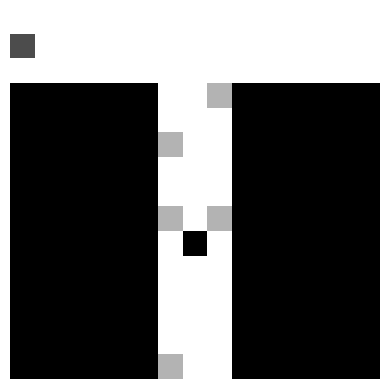

Row: 8 Col: 7 Reward: 0


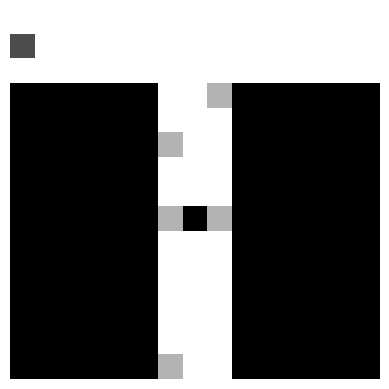

Row: 7 Col: 7 Reward: 0


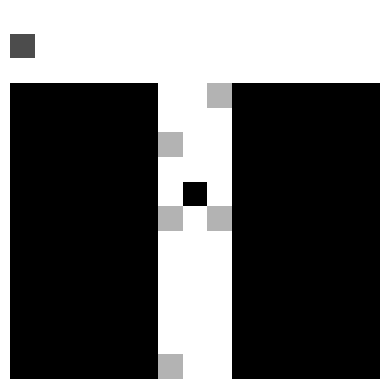

Row: 6 Col: 7 Reward: 0


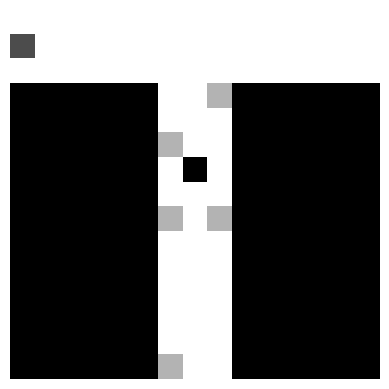

Row: 5 Col: 7 Reward: 0


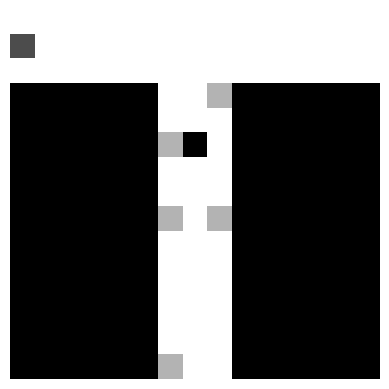

Row: 4 Col: 7 Reward: 1


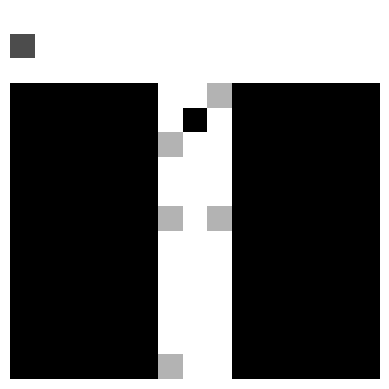

Row: 3 Col: 7 Reward: 0


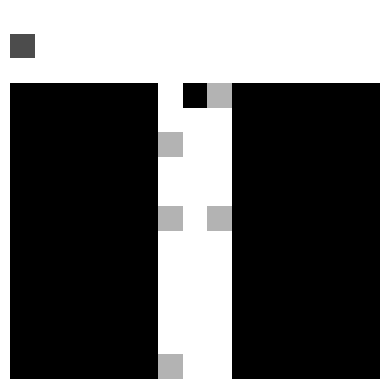

Row: 2 Col: 7 Reward: -1


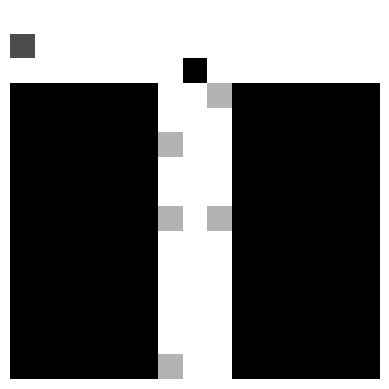

Taking decision
Action: 2
Row: 1 Col: 8 Reward: 0


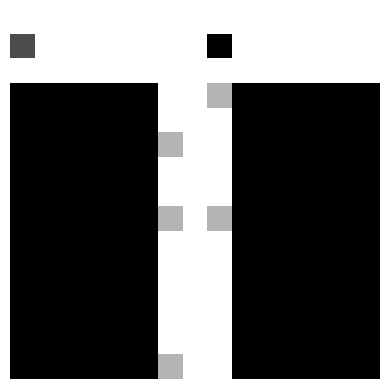

Row: 1 Col: 9 Reward: 0


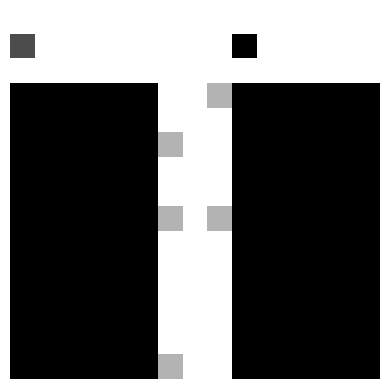

Row: 1 Col: 10 Reward: 0


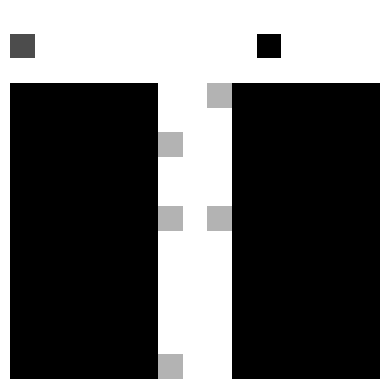

Row: 1 Col: 11 Reward: 0


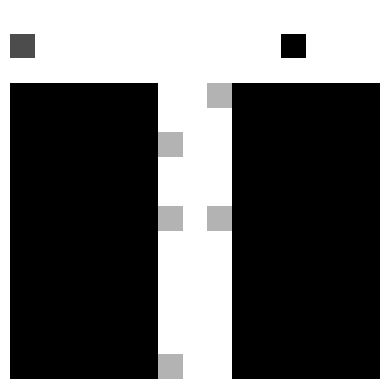

Row: 1 Col: 12 Reward: 0


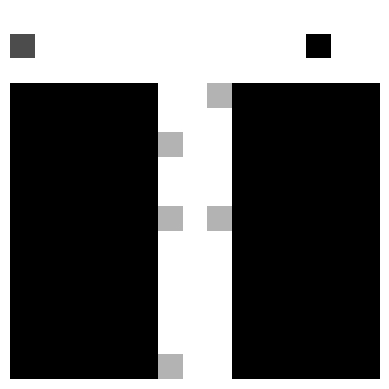

Row: 1 Col: 13 Reward: 0


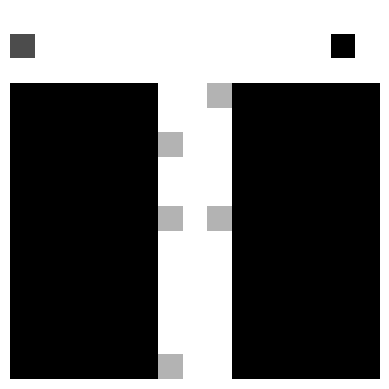

Row: 1 Col: 14 Reward: 5
Episode 3 completed.
Final Reward: 5


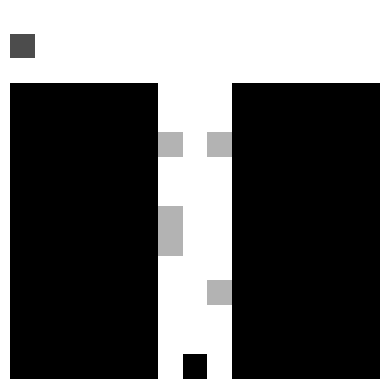

Row: 13 Col: 7 Reward: 0


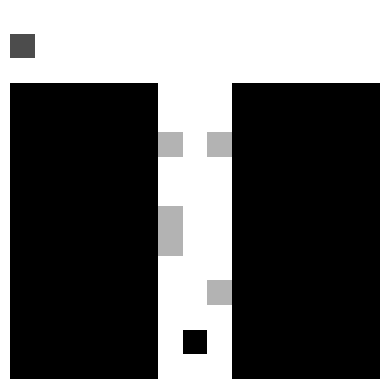

Row: 12 Col: 7 Reward: 0


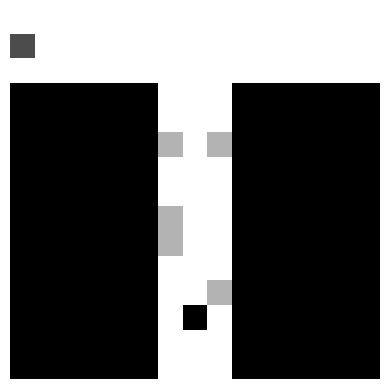

Row: 11 Col: 7 Reward: 0


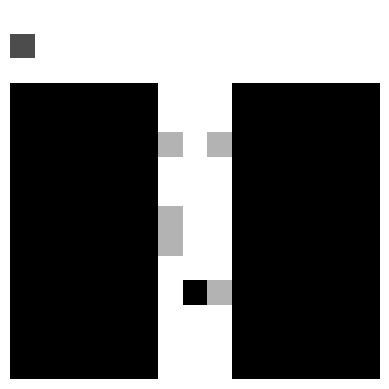

Row: 10 Col: 7 Reward: -1


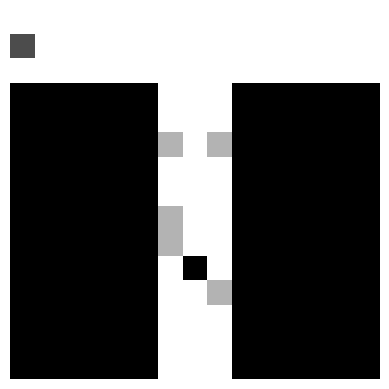

Row: 9 Col: 7 Reward: 0


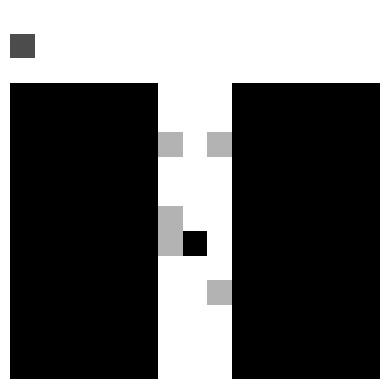

Row: 8 Col: 7 Reward: 1


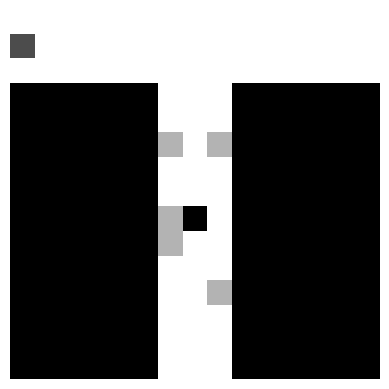

Row: 7 Col: 7 Reward: 1


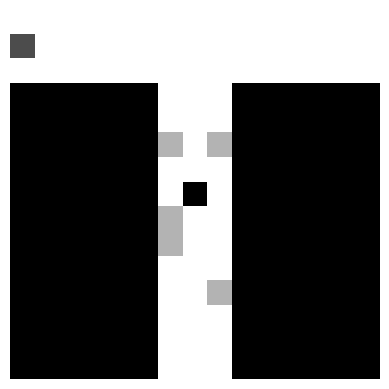

Row: 6 Col: 7 Reward: 0


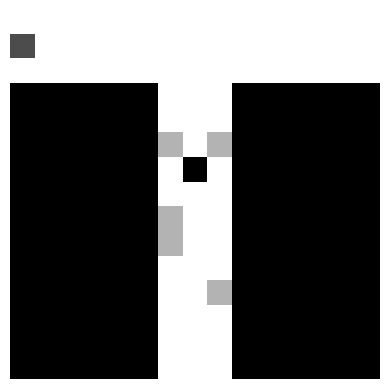

Row: 5 Col: 7 Reward: 0


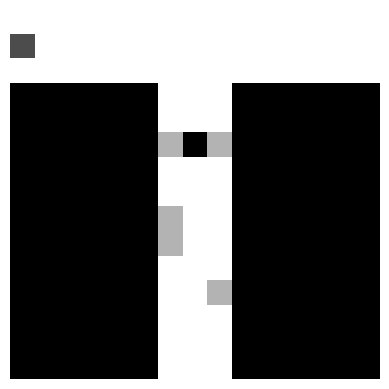

Row: 4 Col: 7 Reward: 0


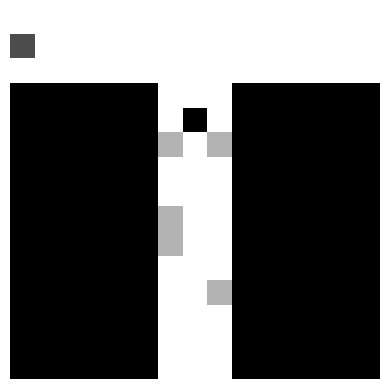

Row: 3 Col: 7 Reward: 0


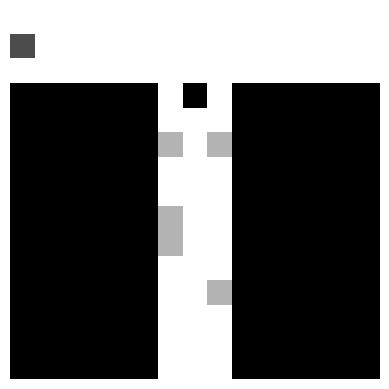

Row: 2 Col: 7 Reward: 0


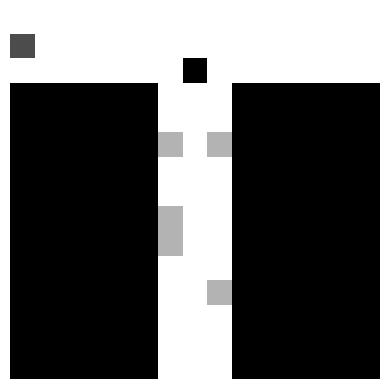

Taking decision
Action: 0
invalid action
Row: 2 Col: 7 Reward: 0


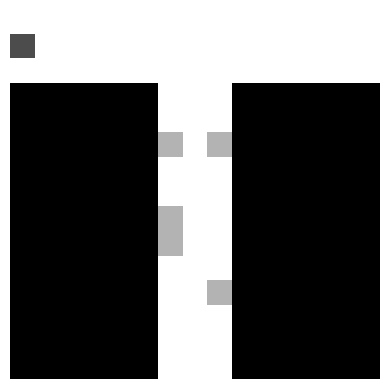

Taking decision
Action: 1
Row: 1 Col: 6 Reward: 0


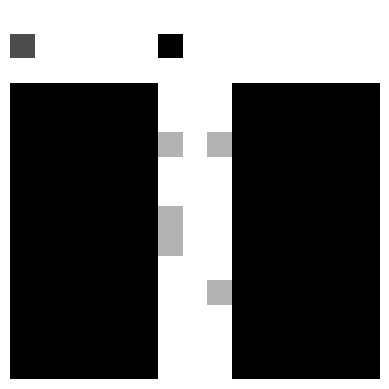

Row: 1 Col: 5 Reward: 0


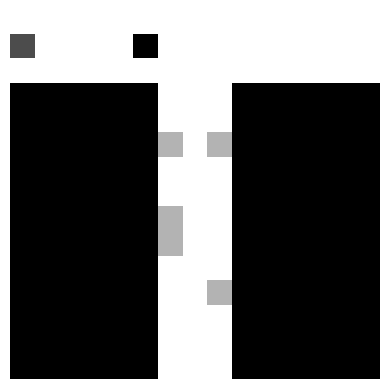

Row: 1 Col: 4 Reward: 0


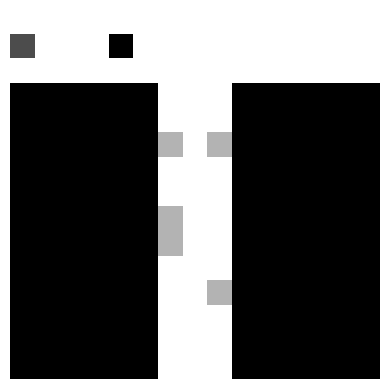

Row: 1 Col: 3 Reward: 0


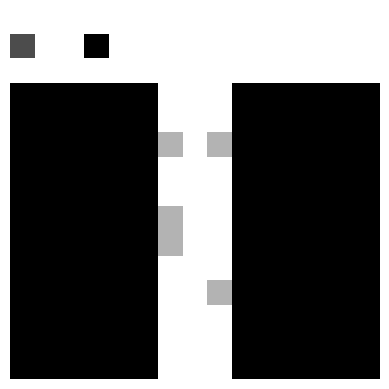

Row: 1 Col: 2 Reward: 0


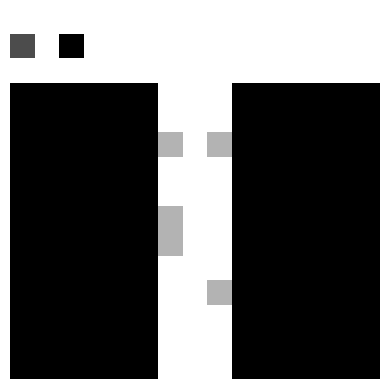

Row: 1 Col: 1 Reward: 0


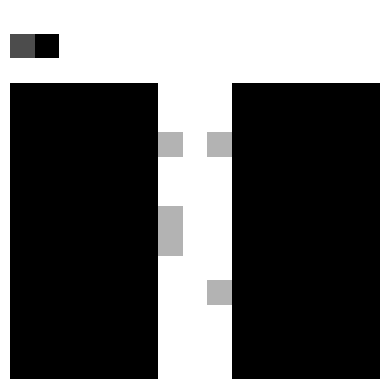

Row: 1 Col: 0 Reward: 5
Episode 4 completed.
Final Reward: 5


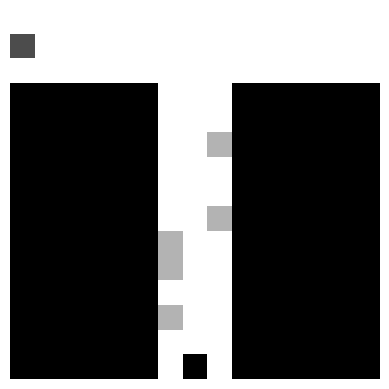

Row: 13 Col: 7 Reward: 0


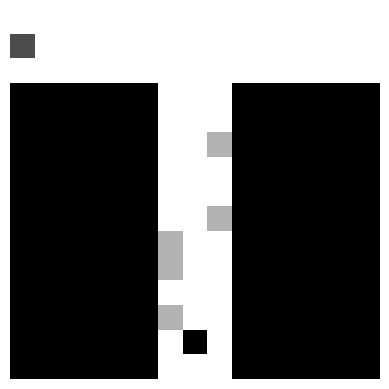

Row: 12 Col: 7 Reward: 0


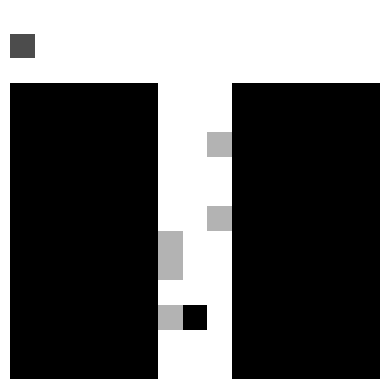

Row: 11 Col: 7 Reward: 1


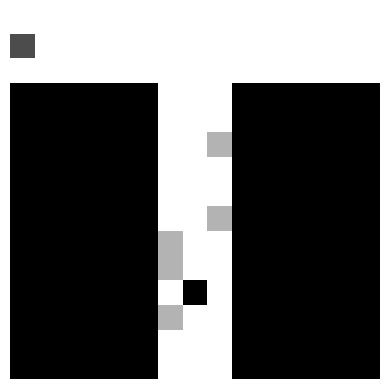

Row: 10 Col: 7 Reward: 0


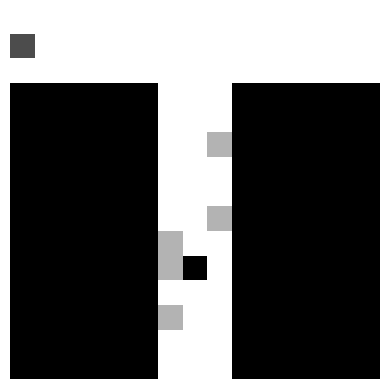

Row: 9 Col: 7 Reward: 1


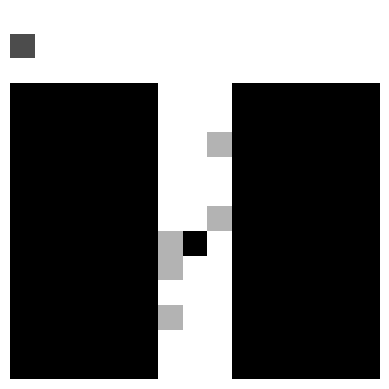

Row: 8 Col: 7 Reward: 1


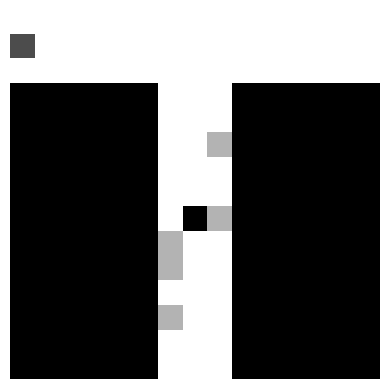

Row: 7 Col: 7 Reward: -1


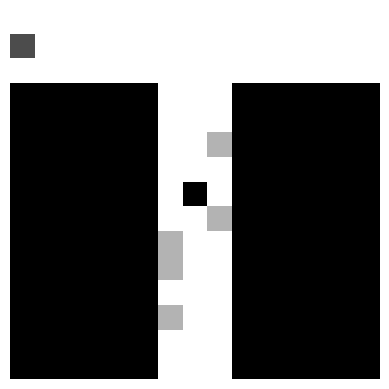

Row: 6 Col: 7 Reward: 0


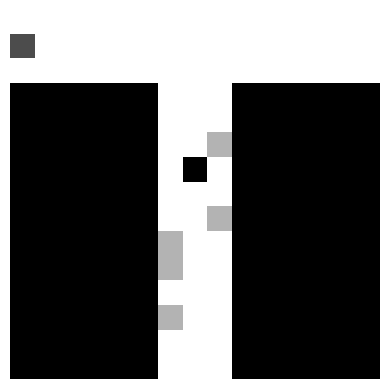

Row: 5 Col: 7 Reward: 0


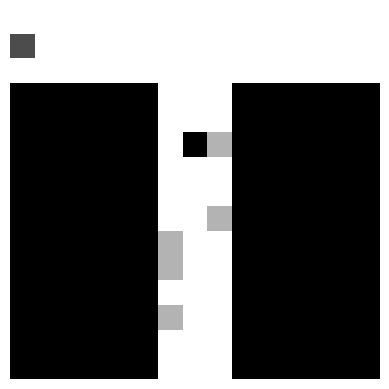

Row: 4 Col: 7 Reward: -1


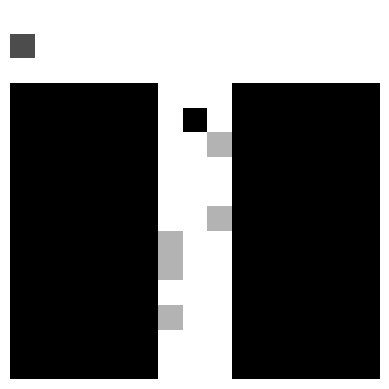

Row: 3 Col: 7 Reward: 0


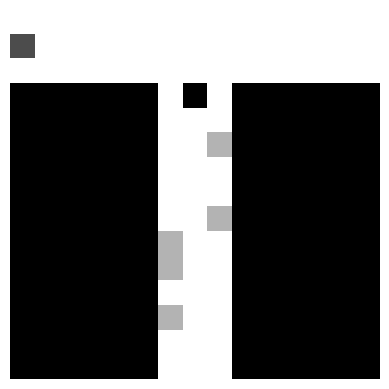

Row: 2 Col: 7 Reward: 0


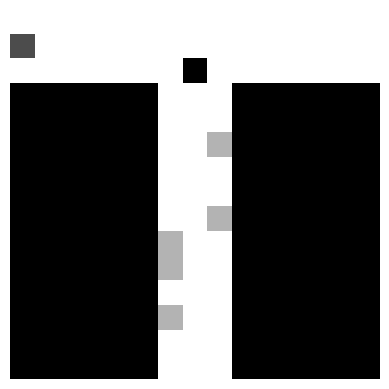

Taking decision
Action: 2
Row: 1 Col: 8 Reward: 0


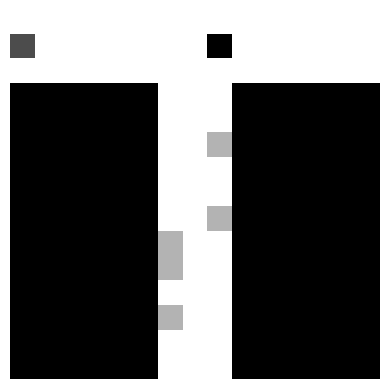

Row: 1 Col: 9 Reward: 0


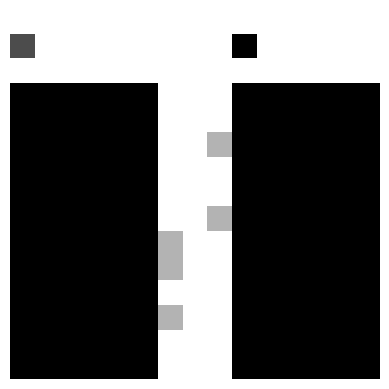

Row: 1 Col: 10 Reward: 0


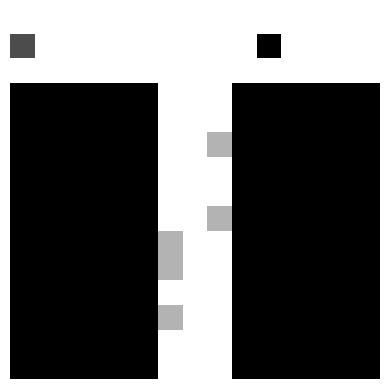

Row: 1 Col: 11 Reward: 0


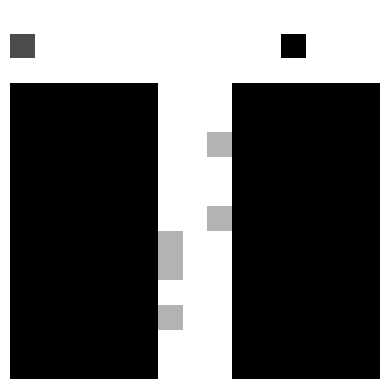

Row: 1 Col: 12 Reward: 0


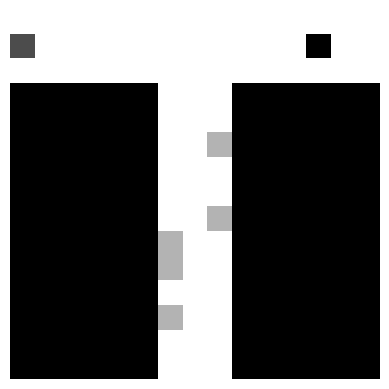

Row: 1 Col: 13 Reward: 0


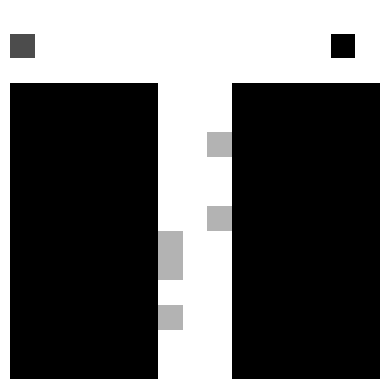

Row: 1 Col: 14 Reward: 5
Episode 5 completed.
Final Reward: 5
Total reward: 25


In [6]:
env = TMazeEnv1()  # Initialize the environment with your grid
totalr = 0

for episode in range(5):  # Run 10 episodes
    observation = env.reset(rat=(14, 7), n_cues_left=3, n_cues_right=2)  # Reset the environment and set the rat at position (14, 7)
    done = False
    row = 14
    col = 7
    action=1
    while not done:
        env.render()
        if row == 2 and col == 7:
            print("Taking decision")
              # Render the current state of the environment
            action = env.action_space.sample()  # Choose a random action
            print("Action:", action)

        observation, row, col, reward, done = env.step(action)  # Take a step in the environment
        print("Row:", row, "Col:", col, "Reward:", reward)


    print("Episode", episode + 1, "completed.")
    print("Final Reward:", reward)
    totalr += reward

print("Total reward:", totalr)


##Q learning

####Overview of q learning

Q-learning is a reinforcement learning algorithm used to find the optimal policy for decision-making in an environment. It maintains a Q-table that stores the expected cumulative rewards for each state-action pair. The algorithm iteratively updates the Q-values based on observed rewards and the maximum Q-value of the next state. This process gradually converges to the optimal Q-values, enabling the agent to make informed decisions. The Q-values guide the agent's policy, determining the best actions to take in each state.

###How it works

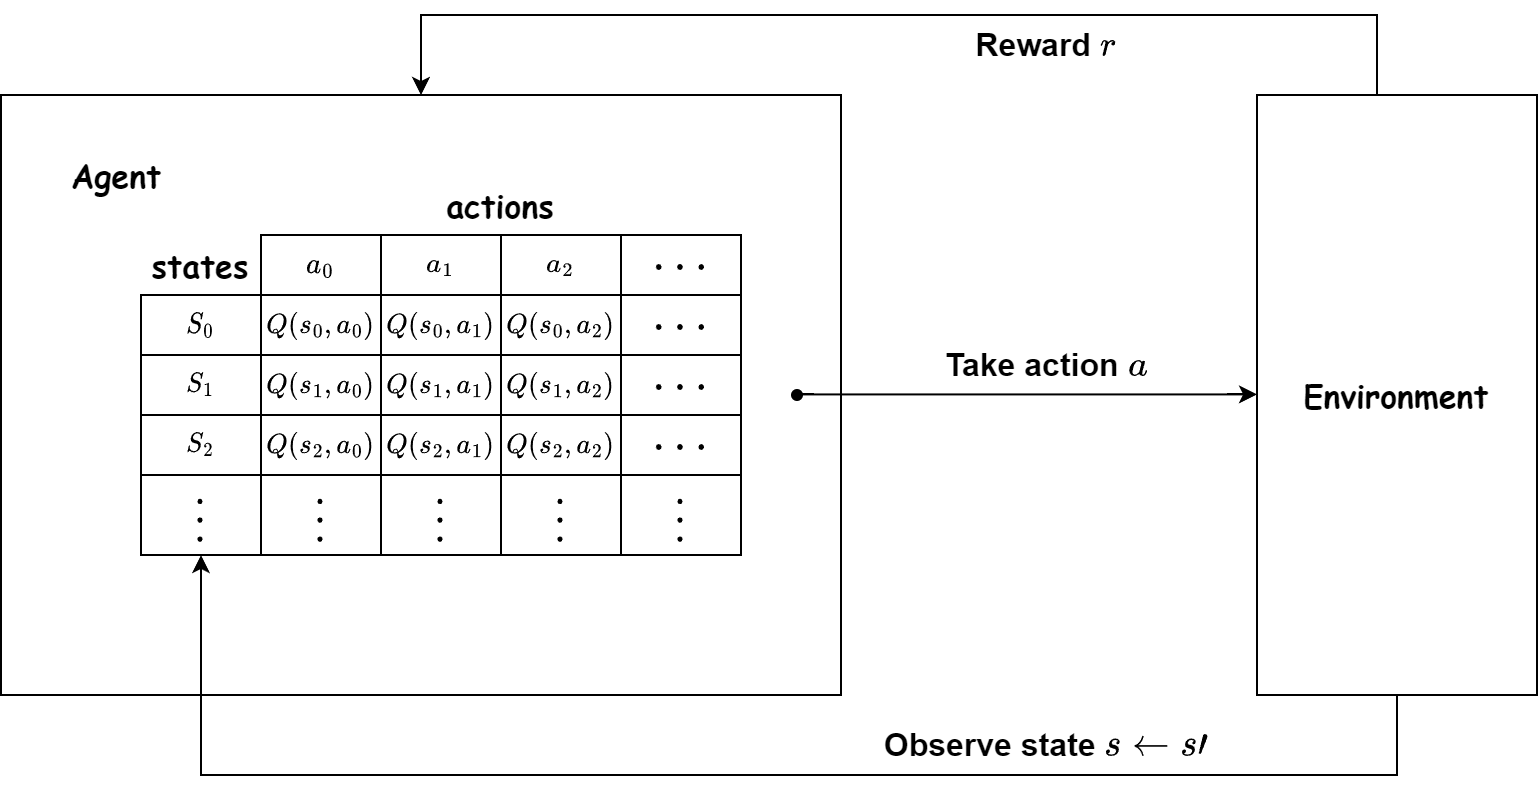


The Q-table is a tabular representation of the Q-values for each state-action pair in a reinforcement learning problem. It is updated during the Q-learning process. Each cell in the table represents the Q-value for a specific state-action pair. The Q-value represents the expected cumulative reward an agent can achieve by taking a particular action in a given state and following an optimal policy thereafter. The Q-table can be represented using LaTeX as follows:



Here, $Q(s,a)$ represents the Q-value for state $s$ and action $a$. For example, $Q(1,1)$ represents the Q-value for State 1 and Action 1.



###Epsilon-Greedy Policy:

The epsilon-greedy policy is a strategy used to balance exploration and exploitation in reinforcement learning. It determines how the agent selects actions based on the Q-values in the Q-table. The policy selects the action with the highest Q-value (exploitation) most of the time, but occasionally chooses a random action (exploration) to explore other possibilities.

The epsilon-greedy policy can be defined using the following equations:

\begin{equation*}
\pi(a|s) = \begin{cases}
1 - \epsilon + \frac{\epsilon}{|\mathcal{A}|}, & \text{if } a = \text{argmax}_a Q(s,a) \
\frac{\epsilon}{|\mathcal{A}|}, & \text{otherwise}
\end{cases}
\end{equation*}

Here, $\pi(a|s)$ represents the probability of selecting action $a$ in state $s$. $|\mathcal{A}|$ represents the total number of possible actions. The parameter $\epsilon$ controls the exploration-exploitation trade-off. If $a$ is the action with the highest Q-value, the probability of selecting $a$ is $1 - \epsilon + \frac{\epsilon}{|\mathcal{A}|}$. Otherwise, the probability of selecting $a$ is $\frac{\epsilon}{|\mathcal{A}|}$.

The epsilon-greedy policy ensures that the agent mostly selects the action with the highest Q-value, but with a small probability $\epsilon$, it explores other actions by selecting them randomly.

###The relationship of q learning and dopamine


The theory and data available today indicate that the phasic activity of midbrain dopamine neurons encodes a reward prediction error used to guide learning throughout the frontal cortex and the basal ganglia. Activity in these dopaminergic neurons is now believed to signal that a subject's estimate of the value of current and future events is in error and indicate the magnitude of this error. This is a kind of combined signal that most scholars active in dopamine studies believe adjusts synaptic strengths in a quantitative manner until the subject's estimate of the value of current and future events is accurately encoded in the frontal cortex and basal ganglia



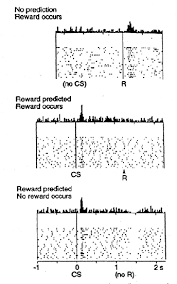

###SIMULATING CA2+ ACTIVITY

 the calcium concentration at time t depends on the previous p time steps, with p being the order of the autoregressive (AR) model. The AR model equation is defined as:

c(t) = ∑(j=1)^(p) γ_j c(t-j) + s(t)

Where:

𝑐(𝑡) represents the calcium concentration at time t.


𝛾_𝑗 represents the autoregression coefficient for the j-th previous time step.


𝑝 is the order of the AR model, indicating the number of previous time steps considered.


𝑠(𝑡) represents the sum of spikes in a given time interval, contributing to the calcium concentration at time t.


The model assumes that the calcium concentration is influenced by the previous p time steps, and the autoregression coefficients 𝛾_𝑗 determine the contribution of each previous time step to the current concentration. The parameter p determines the dynamics of the rise in calcium concentration. A lower p value (e.g., p = 1) implies an instantaneous increase in calcium concentration, while a higher p value (e.g., p = 2) captures more detailed rise dynamics.



Knowing that lets now implement a q learning agent who uses an epsilon greedy strategy

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def epsilon_greedy(Q, epsilon):
    if np.random.random() < epsilon:
        # Choose a random action between 1 and 2
        return env.action_space.sample()
    else:
        # Choose the action with the highest Q-value
        return np.argmax(Q) +1

In [8]:
num_episodes=100#thousand episodes is like stimulating a thousand neurons

# Define the TD learning parameters
alpha = 0.001  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 0.7  # Epsilon for epsilon-greedy strategy
decay_rate=0.95

In [9]:
!apt install ffmpeg

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:4.2.7-0ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.


In [10]:
!pip install opencv-python-headless
import cv2



Lets first perform a fairly easy task where there is only a single cue on the right indicating the reward is on the right.We want to check the total cumulative reward and TD error for this task

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation, ImageMagickWriter
import os
import matplotlib.colors as mlp_colors
from IPython.display import HTML,clear_output


import numpy as np
import tensorflow as tf
class DQN:
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.hidden_dim = hidden_dim
        self.model = self.create_model()

    def create_model(self):
        model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(self.hidden_dim, input_shape=(self.state_dim,), activation='relu'),
            tf.keras.layers.Dense(self.hidden_dim, activation='relu'),
            tf.keras.layers.Dense(self.action_dim, activation='linear')
        ])
        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam())
        return model

    def update(self, states, targets):
        self.model.fit(states, targets, epochs=1, verbose=0)

    def get_q_values(self, state):
        state = tf.expand_dims(state, axis=0)  # Expand dimensions to match model input shape
        return self.model.predict(state)[0]

class DQNAgent:
    def __init__(self, gamma=0.9, epsilon=0.7, epsilon_decay_rate=0.9):
        self.env = TMazeEnv1()
        self.state_dim = 2 #  STATE IS LOCATION OF THE MOUSE=(ROW,COL) from 14,7 to 2,7
        self.action_dim = 2  # assuming the environment provides action dimension
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay_rate = epsilon_decay_rate
        self.dqn = DQN(self.state_dim, self.action_dim)

    """
    def epsilon_greedy(Q, epsilon):
    if np.random.random() < epsilon:
        # Choose a random action between 1 and 2
        return env.action_space.sample()
    else:
        # Choose the action with the highest Q-value
        return np.argmax(Q) +1
    """

    def epsilon_greedy(self, state):
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()  # take a random action
        else:
            q_values = self.dqn.get_q_values(state)
            return np.argmax(q_values)+1  # take the best action

    def run_episodes(self, n_cues_left, n_cues_right):
        Q = np.zeros(2)

        # Define the TD learning parameters
        alpha = 0.1  # Learning rate
        gamma = 0.9  # Discount factor
        epsilon = 0.7  # Epsilon for epsilon-greedy strategy
        decay_rate=0.9

        num_steps = 18  # Assuming a corridor length of 13 steps
        num_episodes = 50  # Set the number of episodes
        avg_td_errors = np.zeros(num_steps)
        td_errors1 = []
        td_error = 0#it will have memory of all previous td error s this makes sense
        tderror_tracker = np.zeros((19, num_episodes))
        reward = 0#essentially it has memory of all previous rewards.change this to have memory of rewards from the last 5 episodes
        reward_t1 = []
        action_history1 = []
        action=0
        total_rewards=[]


        for episode in range(num_episodes):
            print("EPISODE",episode)
            # Reset the environment and set the rat at position (14, 7)
            observation = env.reset(rat=(14, 7), n_cues_left=n_cues_left, n_cues_right=n_cues_right)
            done = False
            row = 14
            col = 7
            step = 0  # Track the step number
            reward_t1 = []
            td_errors1 = []
            episode_action_history = []  # Action history for the current episode
            total_reward=0
            state=[]
            next_state=[13,7]
            next_state_array=np.array(next_state)

            next_state_tensor = tf.convert_to_tensor([next_state], dtype=tf.float32)
            next_q_values = self.dqn.get_q_values(next_state)
            while not done:
                #env.render()
                state=[row,col]
                state_tensor = tf.convert_to_tensor(state, dtype=tf.float32)
                q_tensor = tf.convert_to_tensor(Q, dtype=tf.float32)
                q_values = self.dqn.get_q_values(state_tensor)
                state_array=np.array(state)
                q_array=np.array(Q)
                if row == 2 and col == 7:
                  action = self.epsilon_greedy(state_tensor)
                  episode_action_history.append(action)

                else:

                 td_error = reward + self.gamma * np.max(next_q_values) - q_values[ action - 1]
                 reward = reward
                observation, row, col, reward, done = env.step(action)

                next_state=[row,col]
                next_state_array=np.array(next_state)

                next_state_tensor = tf.convert_to_tensor([next_state], dtype=tf.float32)
                next_q_values = self.dqn.get_q_values(next_state)
                #print("Row:", row, "Col:", col, "Reward:", reward, "action", action, "td_error", td_error)
                td_error = reward + self.gamma * np.max(next_q_values) - q_values[ action - 1]  # Calculate the TD error
                #Q[action - 1] += alpha * td_error  # Update the Q-value for the current action
                #i am not using the td error to make the updates here as the neural network has an update func
                self.dqn.update(state_array.reshape(1, -1), q_array.reshape(1, -1))

                td_errors1.append(td_error)  # Append the TD error to the list
                reward_t1.append(reward)
                action_history1.append(episode_action_history)
                rd_error = 0
                reward = 0
                step+=1




            tderror_tracker[:len(td_errors1), episode] = np.array(td_errors1[:19])
            self.epsilon *= self.epsilon_decay_rate
            total_rewards.append(sum(reward_t1))

        #Calculate the average TD error for each step
        avg_td_errors = np.mean(tderror_tracker, axis=1)  # TD error per step
        avg_error_per_episode = np.mean(tderror_tracker, axis=0)  # TD error per episode
        print("TOTAL REWARD", np.sum(avg_error_per_episode))

        # Smooth the TD error data using a moving average
        window_size = 3  # Adjust the window size as desired
        smoothed_td_errors = np.convolve(avg_td_errors, np.ones(window_size)/window_size, mode='same')

        # Plot the smoothed TD error data
        plt.plot(range(len(avg_td_errors)), smoothed_td_errors, '-k')

        plt.xlabel('Step')
        plt.ylabel('TD Error')
        plt.title('Smoothed TD Error')
        plt.show()
        noise_level=0.1
        num_neurons = tderror_tracker.shape[0]
        gcamp_kernel = np.random.rand(num_neurons)
        fluorescence_episode = []
        delta_fluorescence_traces=[1]
        total_fluorescence_traces=[]
        ratio=[]

        delta_fluorescence_traces = []
        total_fluorescence_traces = []
        time=tderror_tracker.shape[1]

        # AR Model Parameters
        #SIMULATING CALCIUM ACTIVITTY
        p = 1  # Order of the AR model
        gamma = np.linspace(0.1, 0.4, p)#the ar coeffiecient
        C_dt = 0.1
        nc = C_dt / time
        num_neurons=10
        calcium_concentration_traces = []
        calcium_concentration_matrix = []

        for i in range(num_neurons):
          for t in range(time):

            spikes = tderror_tracker[:, t]

            calcium_concentration = np.convolve(gamma, spikes) + np.sum(spikes) * nc


            calcium_concentration_traces.append(calcium_concentration)
          calcium_concentration_matrix.append(calcium_concentration)
        calc_array = np.array(calcium_concentration_matrix)
        print(calc_array.shape)
        sum_calc=np.sum(calc_array,axis=1)
        # Plot the calcium concentration traces
        plt.figure(figsize=(10, 6))
        for i in range(10):
            calcium_trace = calcium_concentration_traces[i]
            plt.plot(calcium_trace)

        plt.xlabel('Time')
        plt.ylabel('Calcium Concentration')
        plt.title('Simulated Calcium Concentration Traces')
        plt.legend()
        plt.show()

      ##SIMULATING and plotting THE FLOUROSCENT ACTIVITY

        baseline = np.random.rand(time)  # Time-dependent baseline
        noise_mean = 0  # Mean of the Gaussian noise
        noise_std = 0.1  # Standard deviation of the Gaussian noise
        num_neurons = 10
        Neu_locs = np.random.rand(num_neurons, 2)  # Random neuron locations in 2D space
        NeuSize = 2  # Average size of neurons

        # Generate 2D Gaussian distribution for each neuron
        x, y = np.meshgrid(np.linspace(-10, 10, 100), np.linspace(-10, 10, 100))  # Grid of x and y coordinates

        combined_neuron_distributions = np.zeros((100 * num_neurons, 100 * num_neurons))  # Initialize combined neuron distribution array
        fluorescence_image = np.zeros_like(combined_neuron_distributions)

        fluorescence_array=[]
        fluorescence_cmap = mlp_colors.LinearSegmentedColormap.from_list('GreenToBlack', ['black', 'green'],N=256)
        fluorescence_norm = mlp_colors.Normalize(vmin=0, vmax=np.max(fluorescence_image))
        for i in range(num_neurons):
            sigma = NeuSize  # Random sigma from a normal distribution
            neuron_distribution = np.exp(-((x - Neu_locs[i, 0]) ** 2 + (y - Neu_locs[i, 1]) ** 2) / (2 * sigma ** 2))#the a(i)   or the spatial extent 3of  aneuron
            neuron_calc_activity=sum_calc[i]

            fluorescence_per_neuron = np.multiply(neuron_distribution, neuron_calc_activity)+ baseline[t]+np.random.normal(noise_mean, noise_std, size=neuron_distribution.shape)
            fluorescence=np.exp(-((x - fluorescence_per_neuron[i, 0]) ** 2 + (y - fluorescence_per_neuron[i, 1]) ** 2) / (2 * sigma ** 2))
          # Calculate the indices for placing the current neuron distribution in the combined array
            start_row = np.random.randint(0, 100 * num_neurons - 100)
            end_row = start_row + 100
            start_col = np.random.randint(0, 100 * num_neurons - 100)
            end_col = start_col + 100
            # Place the current neuron distribution in the appropriate location within the combined array
            combined_neuron_distributions[start_row:end_row, start_col:end_col] = neuron_distribution
            fluorescence_image[start_row:end_row, start_col:end_col] = fluorescence
            fluorescence_array.append(fluorescence)
        fluorescence_combined_array=[]
        combined_fl_distributions=np.zeros((100 * num_neurons, 100 * num_neurons))
        neu_deu=[]
        for i in range(num_neurons):
          sigma = NeuSize  # Random sigma from a normal distribution
          neuron_distribution = np.exp(-((x - Neu_locs[i, 0]) ** 2 + (y - Neu_locs[i, 1]) ** 2) / (2 * sigma ** 2))#the a(i)   or the spatial extent 3of  aneuron
          neu_deu.append(neuron_distribution)
        for t in range(int(time)):

          combined_fl_distributions = np.zeros((100 * num_neurons, 100 * num_neurons))  # Create a new array for each time step
          for i in range(num_neurons):
            sigma=NeuSize
            neuron_calc_activity=sum_calc[i]
            fluorescence_per_neuron_per_unit_time = np.multiply(neu_deu[i], neuron_calc_activity)+ baseline[t]+np.random.normal(noise_mean, noise_std, size=neu_deu[i].shape)
            fluorescence_distribution_per_neuron_per_unit_time=np.exp(-((x - fluorescence_per_neuron_per_unit_time[i, 0]) ** 2 + (y - fluorescence_per_neuron_per_unit_time[i, 1]) ** 2) / (2 * sigma ** 2))
            # Calculate the indices for placing the current neuron distribution in the combined array
            start_row = np.random.randint(0, 100 * num_neurons - 100)
            end_row = start_row + 100
            start_col = np.random.randint(0, 100 * num_neurons - 100)
            end_col = start_col + 100
            # Place the current neuron distribution in the appropriate location within the combined array
            combined_fl_distributions[start_row:end_row, start_col:end_col] = fluorescence_distribution_per_neuron_per_unit_time

          fluorescence_combined_array.append(combined_fl_distributions)
        # Plot the combined neuron distributions
        plt.figure(figsize=(10, 6))
        plt.imshow(combined_neuron_distributions, cmap='gray')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title(f'Calcium Activity of {num_neurons} Neurons')

        plt.show()

        plt.figure(figsize=(10, 6))
        plt.imshow(fluorescence_image,fluorescence_cmap)
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title(f'Flourosence Activity of {num_neurons} Neurons')

        plt.show()

        frames = [] # for storing the generated images
        fig = plt.figure()

        for i in range(len(fluorescence_combined_array)):
            frames.append([plt.imshow(fluorescence_combined_array[i], fluorescence_cmap,animated=True)])

        ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True,
                                        repeat_delay=1000)
        ani.save('/content/fluorescence_animation.mp4')
        from IPython.display import Video

        video_path = '/content/fluorescence_animation.mp4'  # Path to your saved video file
        from IPython.display import HTML
        from base64 import b64encode

        def show_video(video_path, video_width = 600):

          video_file = open(video_path, "r+b").read()

          video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
          return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")

        show_video(video_path)




        """
        from google.colab.patches import cv2_imshow
        import time

        cap = cv2.VideoCapture(video_path)

        while cap.isOpened():
        #while True:
          ok, frame = cap.read()

          if not ok:
            break

          if ok:


            # as you read
            clear_output(wait=True)
            cv2_imshow(frame)
            #delay time to update frame
            time.sleep(1.1)

          if cv2.waitKey(1100) & 0xFF == ord('q'):
            break

        cap.release()
        cv2.destroyAllWindows()
        """

        # Create a figure with two subplots
        fig, (ax1, ax2,ax3,ax4) = plt.subplots(4, 1, figsize=(8, 6))

        # Plot the reward per step
        stepss = range(len(reward_t1))
        ax1.vlines(stepss, [0], reward_t1, colors='blue')
        ax1.set_xlabel('Step')
        ax1.set_ylabel('Reward')
        ax1.set_title('Reward per Step')

        # Plot the TD error per step

        ax2.plot(range(len(avg_td_errors)), avg_td_errors, marker='o', linestyle='-')
        ax2.set_xlabel('Step')
        ax2.set_ylabel('td error')
        ax2.set_title('TD Error per Step')


            # Plot the total reward per episode
        episodes = range(1, num_episodes + 1)
        ax3.plot(episodes, total_rewards, marker='o', linestyle='-')
        ax3.set_xlabel('Episode')
        ax3.set_ylabel('Total Reward')
        ax3.set_title('Total Reward per Episode')

                # Plot the avg td error per episode
        episodes = range(1, num_episodes + 1)
        ax4.plot(episodes, avg_error_per_episode, linestyle='-')
        ax4.set_xlabel('Episode')
        ax4.set_ylabel('average td error')
        ax4.set_title('TD Error per Episode')

        # Adjust the layout to prevent overlapping of subplots
        plt.tight_layout()

        # Display the plot
        plt.show()











In [51]:
agent = DQNAgent()

Here we can check the mouse's performance for different number of cues on each side

EPISODE 0
1/1 [==============================] - 0s 20ms/step
EPISODE 1
1/1 [==============================] - 0s 33ms/step
EPISODE 2
1/1 [==============================] - 0s 22ms/step
EPISODE 3
1/1 [==============================] - 0s 20ms/step
EPISODE 4
1/1 [==============================] - 0s 31ms/step
EPISODE 5
1/1 [==============================] - 0s 23ms/step
EPISODE 6
1/1 [==============================] - 0s 20ms/step
EPISODE 7
1/1 [==============================] - 0s 46ms/step
EPISODE 8
1/1 [==============================] - 0s 20ms/step
EPISODE 9
1/1 [==============================] - 0s 22ms/step
EPISODE 10
1/1 [==============================] - 0s 31ms/step
EPISODE 11
1/1 [==============================] - 0s 20ms/step
EPISODE 12
1/1 [==============================] - 0s 23ms/step
EPISODE 13
1/1 [==============================] - 0s 33ms/step
EPISODE 14
1/1 [==============================] - 0s 20ms/step
EPISODE 15
1/1 [==============================] - 0s 21ms/step
EP

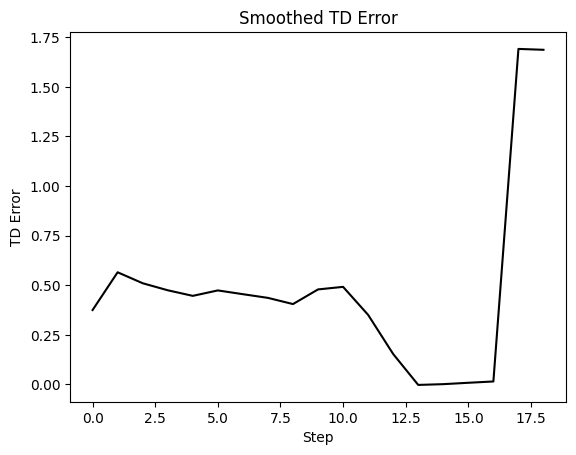

(10, 19)


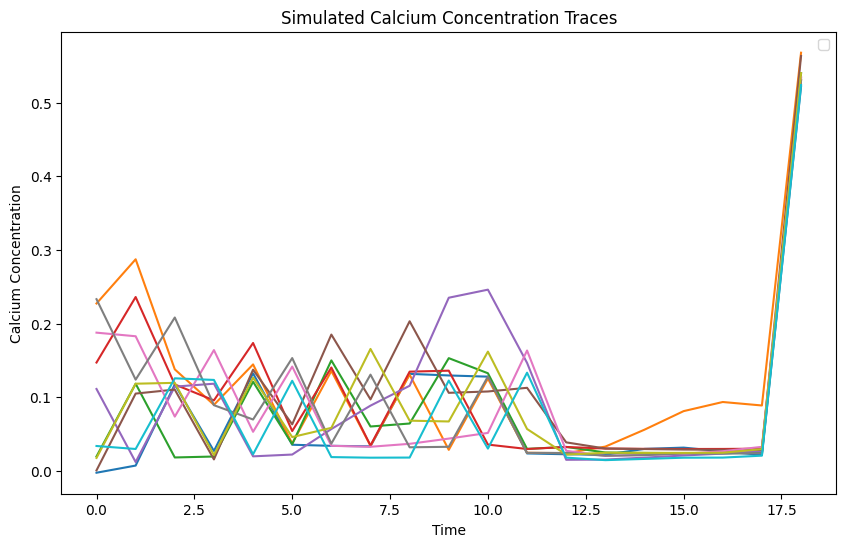

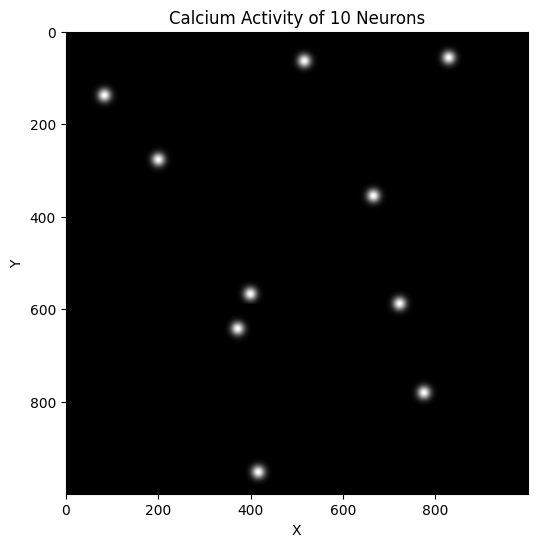

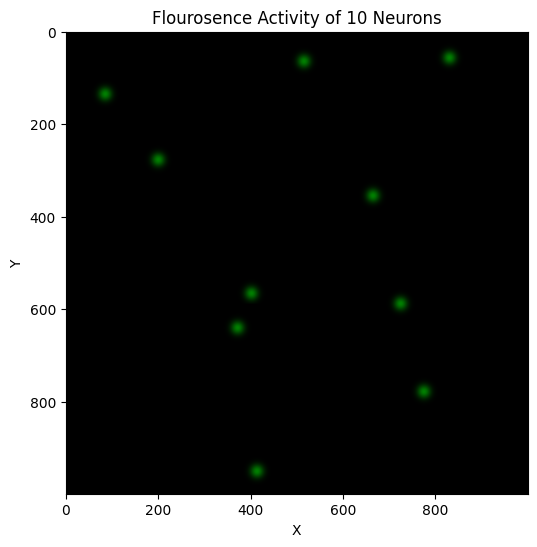

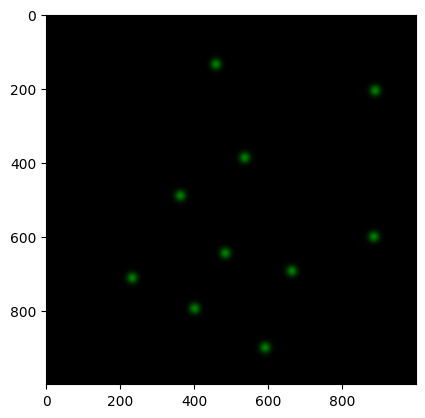

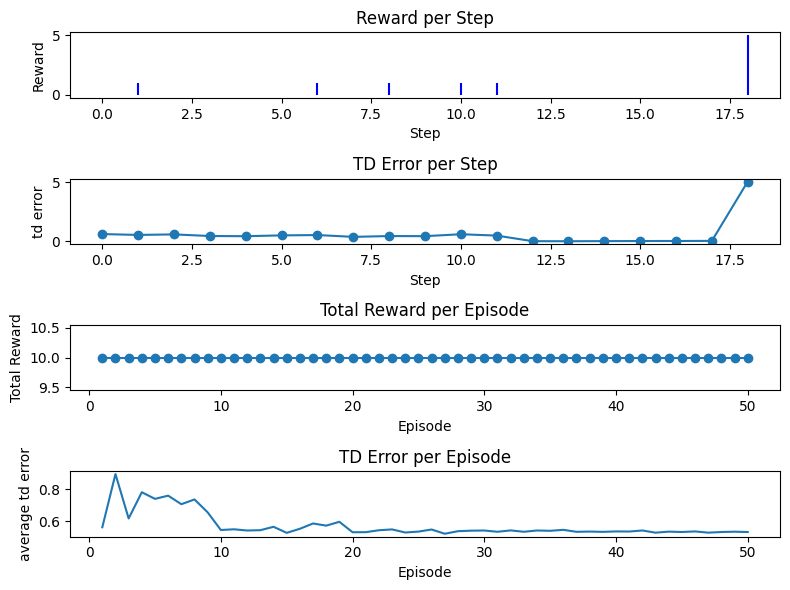

In [46]:
# initialize agent

# Train the agent
n_cues_left = 5  # replace with the actual number
n_cues_right = 0  # replace with the actual number
agent.run_episodes(n_cues_left, n_cues_right)

EPISODE 0
1/1 [==============================] - 0s 30ms/step
invalid action
1/1 [==============================] - 0s 33ms/step
EPISODE 1
1/1 [==============================] - 0s 24ms/step
invalid action
1/1 [==============================] - 0s 40ms/step
EPISODE 2
1/1 [==============================] - 0s 21ms/step
EPISODE 3
1/1 [==============================] - 0s 38ms/step
EPISODE 4
1/1 [==============================] - 0s 27ms/step
EPISODE 5
1/1 [==============================] - 0s 35ms/step
EPISODE 6
1/1 [==============================] - 0s 21ms/step
EPISODE 7
1/1 [==============================] - 0s 22ms/step
EPISODE 8
1/1 [==============================] - 0s 32ms/step
EPISODE 9
1/1 [==============================] - 0s 21ms/step
EPISODE 10
1/1 [==============================] - 0s 20ms/step
invalid action
1/1 [==============================] - 0s 20ms/step
EPISODE 11
1/1 [==============================] - 0s 31ms/step
EPISODE 12
1/1 [==============================] - 0s 

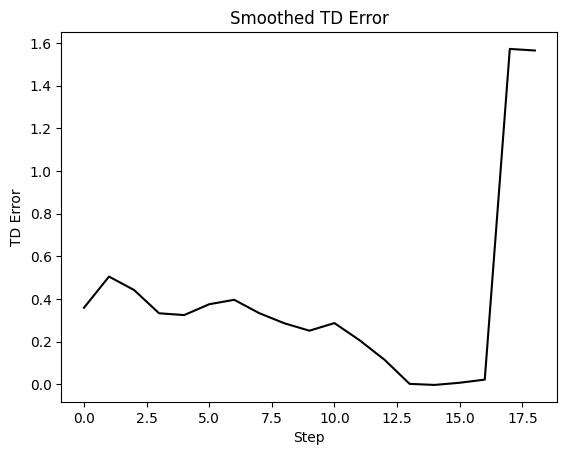

(10, 19)


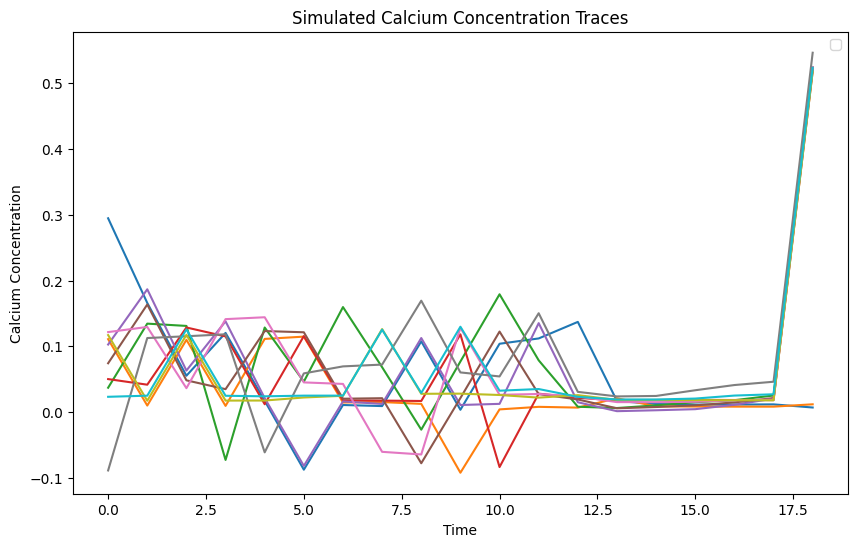

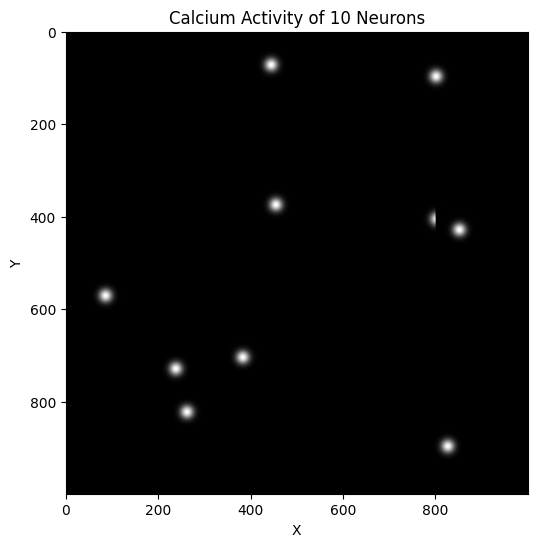

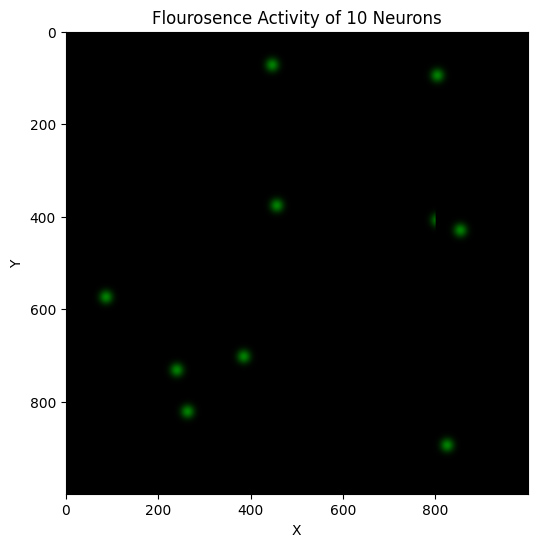

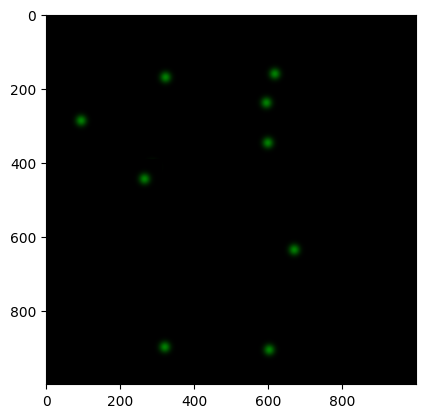

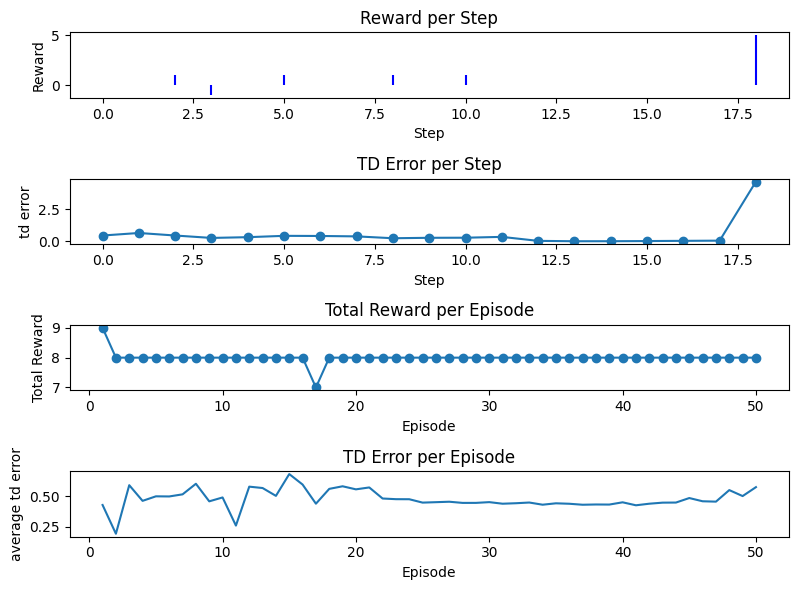

In [52]:
# Example usage
n_cues_left = 5
n_cues_right = 2
agent.run_episodes(n_cues_left, n_cues_right)


EPISODE 0
1/1 [==============================] - 0s 23ms/step


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1/1 [==============================] - 0s 28ms/step
EPISODE 1
1/1 [==============================] - 0s 20ms/step
EPISODE 2
1/1 [==============================] - 0s 21ms/step
EPISODE 3
1/1 [==============================] - 0s 32ms/step
EPISODE 4
1/1 [==============================] - 0s 22ms/step
EPISODE 5
1/1 [==============================] - 0s 22ms/step
EPISODE 6
1/1 [==============================] - 0s 30ms/step
EPISODE 7
1/1 [==============================] - 0s 25ms/step
EPISODE 8
1/1 [==============================] - 0s 22ms/step
EPISODE 9
1/1 [==============================] - 0s 21ms/step
EPISODE 10
1/1 [==============================] - 0s 26ms/step
EPISODE 11
1/1 [==============================] - 0s 22ms/step
EPISODE 12
1/1 [==============================] - 0s 22ms/step
EPISODE 13
1/1 [==============================] - 0s 28ms/step
EPISODE 14
1/1 [==============================] - 0s 21ms/step
EPISODE 15
1/1 [==============================] - 0s 32ms/step
EPISODE 16
1

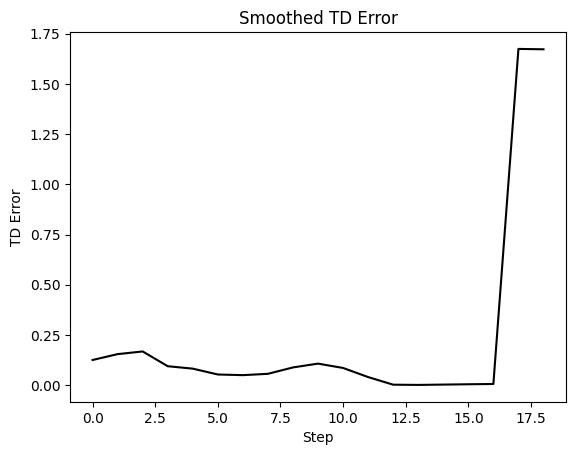

(10, 19)


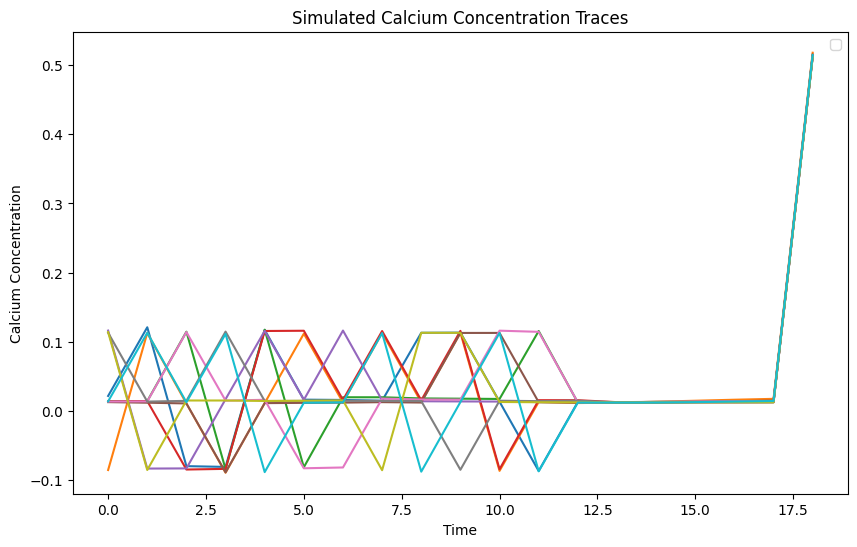

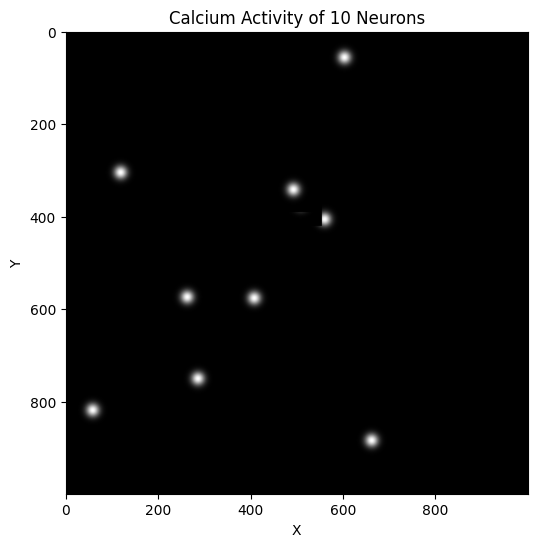

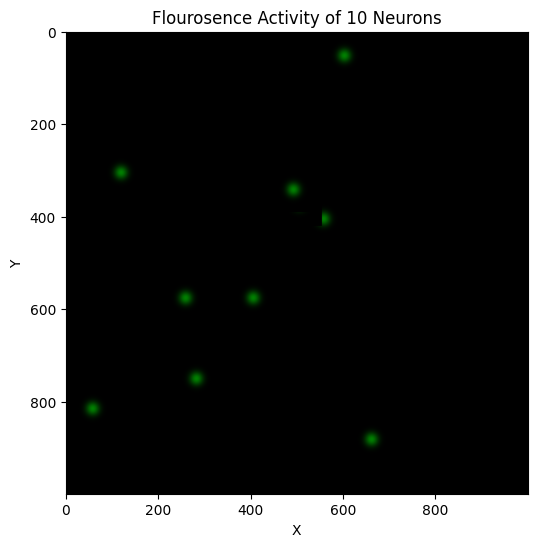

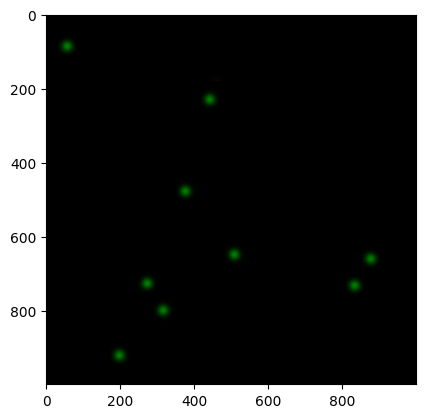

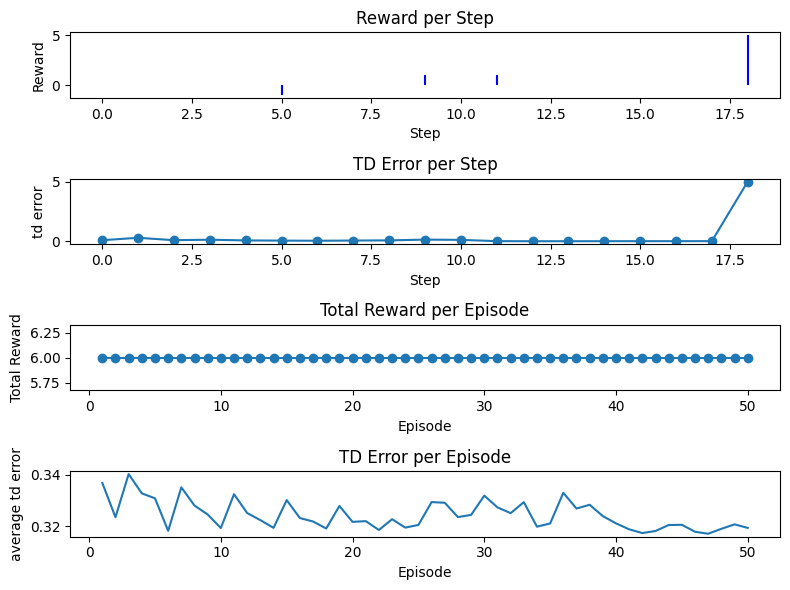

In [54]:
# Example usage
n_cues_left = 5
n_cues_right = 4
agent.run_episodes(n_cues_left, n_cues_right)

EPISODE 0
1/1 [==============================] - 0s 25ms/step
EPISODE 1
1/1 [==============================] - 0s 24ms/step
EPISODE 2
1/1 [==============================] - 0s 25ms/step
EPISODE 3
1/1 [==============================] - 0s 20ms/step
EPISODE 4
1/1 [==============================] - 0s 21ms/step
EPISODE 5
1/1 [==============================] - 0s 23ms/step
EPISODE 6
1/1 [==============================] - 0s 25ms/step
EPISODE 7
1/1 [==============================] - 0s 21ms/step
EPISODE 8
1/1 [==============================] - 0s 22ms/step
EPISODE 9
1/1 [==============================] - 0s 22ms/step
EPISODE 10
1/1 [==============================] - 0s 28ms/step
EPISODE 11
1/1 [==============================] - 0s 22ms/step
EPISODE 12
1/1 [==============================] - 0s 33ms/step
EPISODE 13
1/1 [==============================] - 0s 21ms/step
EPISODE 14
1/1 [==============================] - 0s 23ms/step
EPISODE 15
1/1 [==============================] - 0s 30ms/step
EP

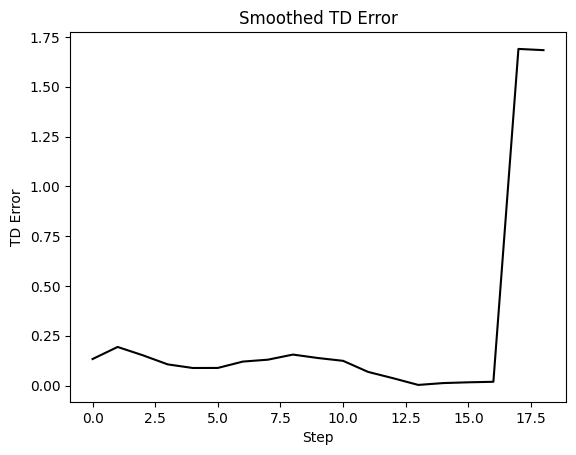

(10, 19)


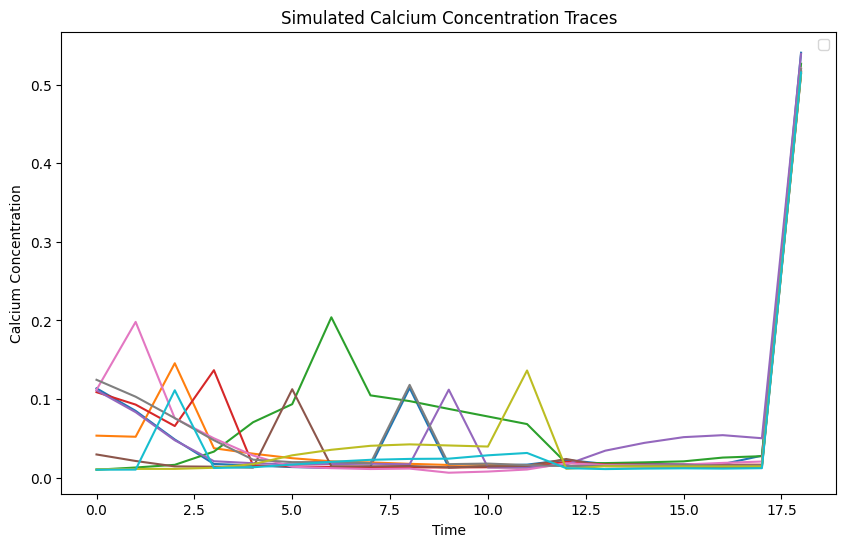

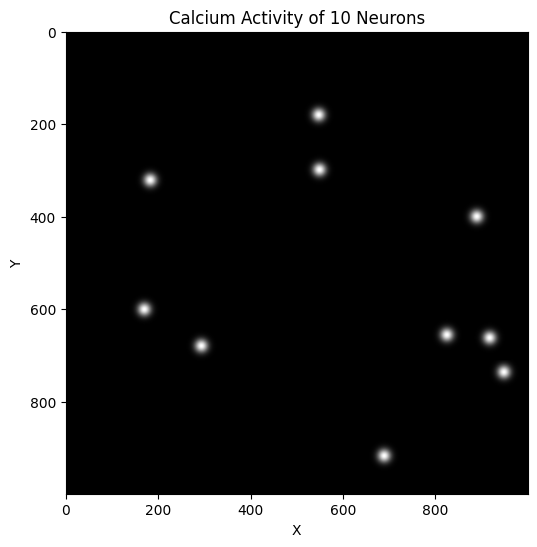

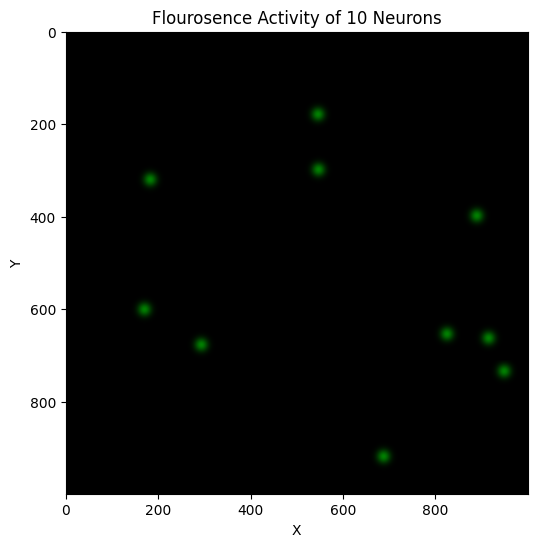

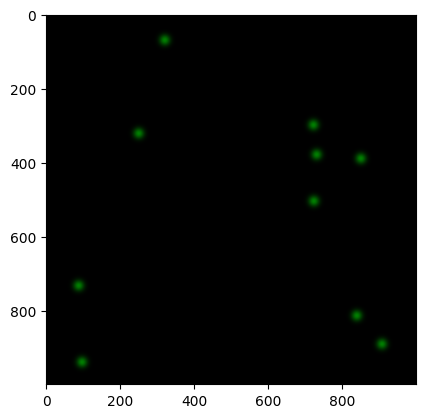

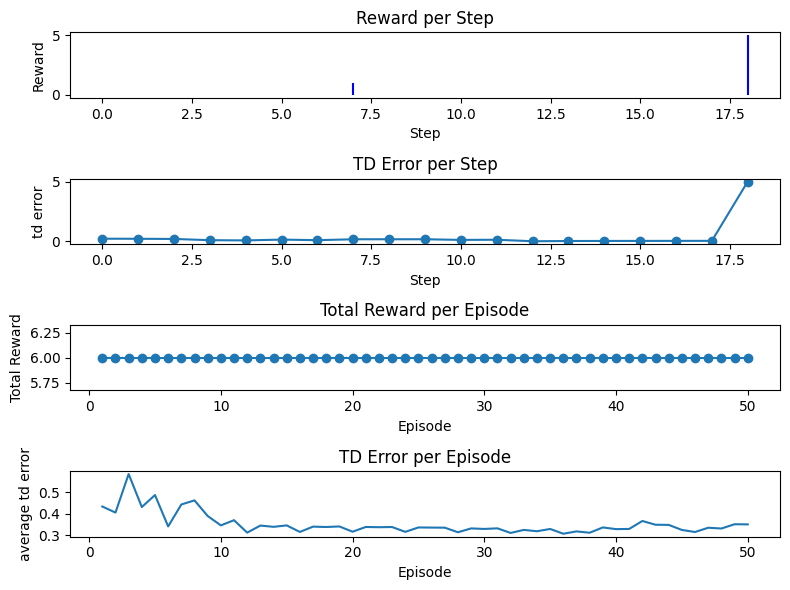

In [53]:
# Example usage
n_cues_left = 1
n_cues_right = 0
agent.run_episodes(n_cues_left, n_cues_right)

##Using an a2c agent

The A2C (Advantage Actor-Critic) algorithm is a type of policy gradient method. In policy gradient methods, the goal is to directly optimize the policy itself without needing an explicit estimate of the value function. However, the actor-critic family of algorithms, which includes A2C, uses a combination of policy optimization and value estimation.

 how A2C works:

Actor: The "actor" in A2C is a neural network that takes as input the current state of the environment and outputs a probability distribution over all possible actions. The actor thus defines the current policy of the agent. Given a state, it proposes what action to take in that state.

Critic: The "critic" in A2C is another neural network that takes as input the current state of the environment and outputs a single number representing the estimated value of that state, under the current policy of the actor. The critic's job is to estimate how good the actions proposed by the actor are.

Advantage Calculation: The key idea in A2C and similar algorithms is the use of an advantage function, which measures the relative value of each action in a given state. The advantage function is calculated as the difference between the actual return received after taking an action and the estimated value of the state according to the critic. This advantage estimate is used to update both the actor and the critic.

Updating the Actor and Critic: The parameters of the actor are updated to make actions with higher than expected returns more probable, and those with lower than expected returns less probable. The parameters of the critic are updated to reduce the difference between the actual returns and its estimates.

Parallel Environments: A2C leverages multiple parallel environments to collect experiences and updates the actor and critic after each step. This allows A2C to achieve a balance between sample complexity and computational complexity.

In [ ]:
!pip install stable-baselines3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.4/178.4 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 22.9 MB/s eta 0:00:00


In [ ]:
from stable_baselines3 import A2C

/usr/local/lib/python3.10/dist-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation, ImageMagickWriter
import os
import matplotlib.colors as mlp_colors
from IPython.display import HTML,clear_output


import numpy as np
import tensorflow as tf
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import random
from torch import optim
import gym
from gym import spaces

class ActorCriticNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(ActorCriticNetwork, self).__init__()
        self.fc1 = nn.Linear(num_inputs, 64)
        self.fc2 = nn.Linear(64, 64)
        self.actor = nn.Linear(64, num_actions)
        self.critic = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        policy = F.softmax(self.actor(x), dim=-1)
        value = self.critic(x)
        return policy, value

# A2C agent
class A2CAgent:
    def __init__(self, num_inputs, num_actions, learning_rate=0.01, gamma=0.99):
        self.network = ActorCriticNetwork(num_inputs, num_actions)
        self.optimizer = torch.optim.Adam(self.network.parameters(), lr=learning_rate)
        self.gamma = gamma

    def select_action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        probs, _ = self.network(state)
        action = torch.multinomial(probs, num_samples=1)
        return action.item()

    def update(self, state, action, reward, next_state, done):
        state = torch.from_numpy(state).float().unsqueeze(0)
        next_state = torch.from_numpy(next_state).float().unsqueeze(0)
        reward = torch.tensor([reward], dtype=torch.float)
        action = torch.tensor([action], dtype=torch.int64)

        _, value = self.network(state)
        _, next_value = self.network(next_state)

        # Calculate target and advantage
        target = reward + (1 - done) * self.gamma * next_value
        td_error = target - value
        advantage = td_error.detach()

        # Compute loss functions
        value_loss = td_error.pow(2)
        policy, _ = self.network(state)
        action_prob = policy.gather(dim=1, index=action.unsqueeze(1)).squeeze()
        policy_loss = -torch.log(action_prob) * advantage

        # Backward pass and optimization
        self.optimizer.zero_grad()
        loss = policy_loss + value_loss
        loss.backward()
        self.optimizer.step()





    def run_episodes(self, n_cues_left, n_cues_right):
        Q = np.zeros(2)

        # Define the TD learning parameters
        alpha = 0.1  # Learning rate
        gamma = 0.9  # Discount factor
        epsilon = 0.7  # Epsilon for epsilon-greedy strategy
        decay_rate=0.9

        num_steps = 18  # Assuming a corridor length of 13 steps
        num_episodes = 50  # Set the number of episodes
        avg_td_errors = np.zeros(num_steps)
        td_errors1 = []
        td_error = 0#it will have memory of all previous td error s this makes sense
        tderror_tracker = np.zeros((19, num_episodes))
        reward = 0#essentially it has memory of all previous rewards.change this to have memory of rewards from the last 5 episodes
        reward_t1 = []
        action_history1 = []
        action=0
        total_rewards=[]





        for episode in range(num_episodes):
            print("EPISODE",episode)
            # Reset the environment and set the rat at position (14, 7)
            observation = env.reset(rat=(14, 7), n_cues_left=n_cues_left, n_cues_right=n_cues_right)
            done = False
            row = 14
            col = 7
            step = 0  # Track the step number
            reward_t1 = []
            td_errors1 = []
            episode_action_history = []  # Action history for the current episode
            total_reward=0
            state=[]
            while not done:
                #env.render()
                state=[row,col]
                state_tensor = tf.convert_to_tensor(state, dtype=tf.float32)
                q_tensor = tf.convert_to_tensor(Q, dtype=tf.float32)
                state_array=np.array(state)
                q_array=np.array(Q)
                if row == 2 and col == 7:
                  action = agent.select_action(state_array)
                  episode_action_history.append(action)

                else:

                 #td_error = reward + gamma * np.max(Q) - Q[action - 1]
                 reward = reward
                observation, row, col, reward, done = env.step(action)
                next_state=[row,col]

                next_state_array=np.array(next_state)
                agent.update(state_array, action, reward, next_state_array, done)
                state = next_state



                #print("Row:", row, "Col:", col, "Reward:", reward, "action", action, "td_error", td_error)
                #td_error = reward + gamma * np.max(Q) - Q[action - 1]  # Calculate the TD error
                #Q[action - 1] += alpha * td_error  # Update the Q-value for the current action
                #self.dqn.update(state_array.reshape(1, -1), q_array.reshape(1, -1))

                #td_errors1.append(td_error)  # Append the TD error to the list
                reward_t1.append(reward)
                action_history1.append(episode_action_history)
                rd_error = 0
                reward = 0
                step+=1




            tderror_tracker[:len(td_errors1), episode] = np.array(td_errors1[:19])
            #self.epsilon *= self.epsilon_decay_rate
            total_rewards.append(sum(reward_t1))

        #Calculate the average TD error for each step
        #avg_td_errors = np.mean(tderror_tracker, axis=1)  # TD error per step
        #avg_error_per_episode = np.mean(tderror_tracker, axis=0)  # TD error per episode
        #print("TOTAL REWARD", np.sum(avg_error_per_episode))

        # Smooth the TD error data using a moving average
        window_size = 3  # Adjust the window size as desired
        #smoothed_td_errors = np.convolve(avg_td_errors, np.ones(window_size)/window_size, mode='same')
        """
        # Plot the smoothed TD error data
        plt.plot(range(len(avg_td_errors)), smoothed_td_errors, '-k')

        plt.xlabel('Step')
        plt.ylabel('TD Error')
        plt.title('Smoothed TD Error')
        plt.show()
        noise_level=0.1
        num_neurons = tderror_tracker.shape[0]
        gcamp_kernel = np.random.rand(num_neurons)
        fluorescence_episode = []
        delta_fluorescence_traces=[1]
        total_fluorescence_traces=[]
        ratio=[]

        delta_fluorescence_traces = []
        total_fluorescence_traces = []
        time=tderror_tracker.shape[1]

        # AR Model Parameters
        #SIMULATING CALCIUM ACTIVITTY
        p = 1  # Order of the AR model
        gamma = np.linspace(0.1, 0.4, p)#the ar coeffiecient
        C_dt = 0.1
        nc = C_dt / time
        num_neurons=10
        calcium_concentration_traces = []
        calcium_concentration_matrix = []

        for i in range(num_neurons):
          for t in range(time):

            spikes = tderror_tracker[:, t]

            calcium_concentration = np.convolve(gamma, spikes) + np.sum(spikes) * nc


            calcium_concentration_traces.append(calcium_concentration)
          calcium_concentration_matrix.append(calcium_concentration)
        calc_array = np.array(calcium_concentration_matrix)
        print(calc_array.shape)
        sum_calc=np.sum(calc_array,axis=1)
        # Plot the calcium concentration traces
        plt.figure(figsize=(10, 6))
        for i in range(10):
            calcium_trace = calcium_concentration_traces[i]
            plt.plot(calcium_trace)

        plt.xlabel('Time')
        plt.ylabel('Calcium Concentration')
        plt.title('Simulated Calcium Concentration Traces')
        plt.legend()
        plt.show()

      ##SIMULATING and plotting THE FLOUROSCENT ACTIVITY

        baseline = np.random.rand(time)  # Time-dependent baseline
        noise_mean = 0  # Mean of the Gaussian noise
        noise_std = 0.1  # Standard deviation of the Gaussian noise
        num_neurons = 10
        Neu_locs = np.random.rand(num_neurons, 2)  # Random neuron locations in 2D space
        NeuSize = 2  # Average size of neurons

        # Generate 2D Gaussian distribution for each neuron
        x, y = np.meshgrid(np.linspace(-10, 10, 100), np.linspace(-10, 10, 100))  # Grid of x and y coordinates

        combined_neuron_distributions = np.zeros((100 * num_neurons, 100 * num_neurons))  # Initialize combined neuron distribution array
        fluorescence_image = np.zeros_like(combined_neuron_distributions)

        fluorescence_array=[]
        fluorescence_cmap = mlp_colors.LinearSegmentedColormap.from_list('GreenToBlack', ['black', 'green'],N=256)
        fluorescence_norm = mlp_colors.Normalize(vmin=0, vmax=np.max(fluorescence_image))
        for i in range(num_neurons):
            sigma = NeuSize  # Random sigma from a normal distribution
            neuron_distribution = np.exp(-((x - Neu_locs[i, 0]) ** 2 + (y - Neu_locs[i, 1]) ** 2) / (2 * sigma ** 2))#the a(i)   or the spatial extent 3of  aneuron
            neuron_calc_activity=sum_calc[i]

            fluorescence_per_neuron = np.multiply(neuron_distribution, neuron_calc_activity)+ baseline[t]+np.random.normal(noise_mean, noise_std, size=neuron_distribution.shape)
            fluorescence=np.exp(-((x - fluorescence_per_neuron[i, 0]) ** 2 + (y - fluorescence_per_neuron[i, 1]) ** 2) / (2 * sigma ** 2))
          # Calculate the indices for placing the current neuron distribution in the combined array
            start_row = np.random.randint(0, 100 * num_neurons - 100)
            end_row = start_row + 100
            start_col = np.random.randint(0, 100 * num_neurons - 100)
            end_col = start_col + 100
            # Place the current neuron distribution in the appropriate location within the combined array
            combined_neuron_distributions[start_row:end_row, start_col:end_col] = neuron_distribution
            fluorescence_image[start_row:end_row, start_col:end_col] = fluorescence
            fluorescence_array.append(fluorescence)
        fluorescence_combined_array=[]
        combined_fl_distributions=np.zeros((100 * num_neurons, 100 * num_neurons))
        neu_deu=[]
        for i in range(num_neurons):
          sigma = NeuSize  # Random sigma from a normal distribution
          neuron_distribution = np.exp(-((x - Neu_locs[i, 0]) ** 2 + (y - Neu_locs[i, 1]) ** 2) / (2 * sigma ** 2))#the a(i)   or the spatial extent 3of  aneuron
          neu_deu.append(neuron_distribution)
        for t in range(int(time)):

          combined_fl_distributions = np.zeros((100 * num_neurons, 100 * num_neurons))  # Create a new array for each time step
          for i in range(num_neurons):
            sigma=NeuSize
            neuron_calc_activity=sum_calc[i]
            fluorescence_per_neuron_per_unit_time = np.multiply(neu_deu[i], neuron_calc_activity)+ baseline[t]+np.random.normal(noise_mean, noise_std, size=neu_deu[i].shape)
            fluorescence_distribution_per_neuron_per_unit_time=np.exp(-((x - fluorescence_per_neuron_per_unit_time[i, 0]) ** 2 + (y - fluorescence_per_neuron_per_unit_time[i, 1]) ** 2) / (2 * sigma ** 2))
            # Calculate the indices for placing the current neuron distribution in the combined array
            start_row = np.random.randint(0, 100 * num_neurons - 100)
            end_row = start_row + 100
            start_col = np.random.randint(0, 100 * num_neurons - 100)
            end_col = start_col + 100
            # Place the current neuron distribution in the appropriate location within the combined array
            combined_fl_distributions[start_row:end_row, start_col:end_col] = fluorescence_distribution_per_neuron_per_unit_time

          fluorescence_combined_array.append(combined_fl_distributions)
        # Plot the combined neuron distributions
        plt.figure(figsize=(10, 6))
        plt.imshow(combined_neuron_distributions, cmap='gray')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title(f'Calcium Activity of {num_neurons} Neurons')

        plt.show()

        plt.figure(figsize=(10, 6))
        plt.imshow(fluorescence_image,fluorescence_cmap)
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title(f'Flourosence Activity of {num_neurons} Neurons')

        plt.show()

        frames = [] # for storing the generated images
        fig = plt.figure()

        for i in range(len(fluorescence_combined_array)):
            frames.append([plt.imshow(fluorescence_combined_array[i], fluorescence_cmap,animated=True)])

        ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True,
                                        repeat_delay=1000)
        ani.save('/content/fluorescence_animation.mp4')
        from IPython.display import Video

        video_path = '/content/fluorescence_animation.mp4'  # Path to your saved video file
        from IPython.display import HTML
        from base64 import b64encode

        def show_video(video_path, video_width = 600):

          video_file = open(video_path, "r+b").read()

          video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"


        show_video(video_path)


        """

        # Create a figure with two subplots
        fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(8, 6))

        # Plot the reward per step
        stepss = range(len(reward_t1))
        ax1.vlines(stepss, [0], reward_t1, colors='blue')
        ax1.set_xlabel('Step')
        ax1.set_ylabel('Reward')
        ax1.set_title('Reward per Step')
        """
        # Plot the TD error per step

        ax2.plot(range(len(avg_td_errors)), avg_td_errors, marker='o', linestyle='-')
        ax2.set_xlabel('Step')
        ax2.set_ylabel('td error')
        ax2.set_title('TD Error per Step')
        """

            # Plot the total reward per episode
        episodes = range(1, num_episodes + 1)
        ax3.plot(episodes, total_rewards, marker='o', linestyle='-')
        ax3.set_xlabel('Episode')
        ax3.set_ylabel('Total Reward')
        ax3.set_title('Total Reward per Episode')
        """
                # Plot the avg td error per episode
        episodes = range(1, num_episodes + 1)
        ax4.plot(episodes, avg_error_per_episode, linestyle='-')
        ax4.set_xlabel('Episode')
        ax4.set_ylabel('average td error')
        ax4.set_title('TD Error per Episode')
        """
        # Adjust the layout to prevent overlapping of subplots
        plt.tight_layout()

        # Display the plot
        plt.show()











In [ ]:
!pip install shimmy

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
agent = A2CAgent(2,2)

In [ ]:
agent.run_episodes(n_cues_left=5, n_cues_right=0)

Streaming output truncated to the last 5000 lines.
invalid action
invalid action
invalid action
invalid action
invalid action
invalid action
invalid action
invalid action
invalid action
invalid action
invalid action
invalid action
invalid action
invalid action
invalid action
invalid action
invalid action
invalid action
invalid action
invalid action
invalid action
invalid action
invalid action
invalid action
invalid action
invalid action
invalid action
invalid action
invalid action
invalid action
invalid action
invalid action
invalid action
invalid action
invalid action
invalid action
invalid action
invalid action
invalid action
invalid action
invalid action
invalid action
invalid action
invalid action
invalid action
invalid action
invalid action
invalid action
invalid action
invalid action
invalid action
invalid action
invalid action
invalid action
invalid action
invalid action
invalid action
invalid action
invalid action
invalid action
invalid action
invalid action
invalid action
inva

#Part 3

##Measuring the parameters of the testing method

###Understanding Calcium imaging

Calcium imaging enables neuroscientists to visualize the activity of hundreds of individual neurons simultaneously using fluorescent activity sensors. Changes in fluorescence indicate fluctuations in intracellular calcium, which is an indirect indicator of neural activity.

The development of genetically encoded calcium indicators (GECIs) has enabled neuroscientists to study specific cell types (e.g., excitatory or inhibitory neurons).

GCaMP, a green fluorescent GECI, is commonly used in calcium imaging experiments since it has been optimized over many generations (currently GCaMP7) for speed, signal-to-noise ratio, expression, and changes in fluorescence .

![image](https://www.mightexbio.com/wp-content/uploads/2020/01/blogpost1figure2_v2.jpg)

**Genetic Sensor Expression**

The first step, and most important, is achieving optimal GECI expression in your animal model.


Neuroscientists employ two methods to express GECIs in the brain: viral expression and transgenic animal models.For our experiment we are working with transgenic mice of the strain DATCre-Ai148D.

 Transgenic animal models are designed to express the GECI throughout the entire brain. Depending on the transgenic model, GECI expression can vary from region to region

**Accessing the fluorescent signal inside the brain.**

We have  surgically implanted a lens into the ventral tegmental area of the midbrain of the mouse to visualize activity.

There are three types of probes (optical cannula, cortical window, GRIN lens) that are used for in vivo calcium imaging. The probe you select is dependent on two main factors:

1)Do you require cellular-resolution imaging?

2)Will you be imaging a deep or superficial brain region?


We have used a GRIN lens  in our experiment as for our project imaging at a good cellular resolution is important.

Optical cannulas enable light to be delivered and collected from the brain. These probes are used in fiber photometry experiments. Due to their design, optical cannulas are only capable of collecting one signal or a population signal, providing no spatial resolution to image individual neurons. Depending on the length of the optical cannula, they can be used to collect a fiber photometry signal from shallow or deep brain regions. Another bonus is optical cannulas are the least invasive to be implanted in the brain because of their compact design, which leads to minimal tissue damage.


Lastly, a GRIN lens is a microendoscopic probe that can be implanted in the brain to image individual neurons. GRIN lenses differ in lengths, enabling neuroscientists to image shallow to deep brain regions (up to 8mm). GRIN lenses are typically limited in diameter (0.5–1mm). Thus, imaging with GRIN lenses provides a relatively small field of view, compared to cortical windows, and the implantation of a large GRIN lens can lead to tissue damage, compared to an optical cannula. However, a GRIN lens is the only imaging probe available to image with cellular-resolution in the brain of a freely-behaving animal.



**Equipment components for imaging**


![image](https://www.mightexbio.com/wp-content/uploads/2020/01/blogpost2_fig3_v2.jpg)

The systems currently available for in vivo calcium imaging are comprised of three main components:

1)**Coupling between the imaging probe and imaging device-**

This coupling may be achieved via an imaging fiber, optical fiber, or the system may be directly mounted onto the head of the animal, such as the miniscope.In our experiment we have used a GRIN lens and a water immersion objective that can be directly positioned above the lens.


2)**Light source and filter set-**

 The correct excitation wavelength must be selected. GCaMP excitation is blue (~470nm) and emission is green (~530nm).Dichroics and filters allow for the transmission of the correct excitation and emission wavelength to the imaging device.

 ![image](https://www.mightexbio.com/wp-content/uploads/2020/01/blogpost3_fig2_2_v2.jpg)

3)**Imaging device-**

Three types of imaging devices are used for in vivo imaging systems: 1) scientific camera, 2) PMT, and 3) photodetector. We have used a PMT as we have elected to use a two-photon microscope.




##Parameters of calcium imaging-

Now that we have understood the intricacies of calcium imaging  lets try to understand the main parameters of the system and how varying them can affect our results

1)**Indicator properties**








**Fluorescence Intensity (F) = QY * ε * C * I**

Where:

F represents the fluorescence intensity.Fluorescence is based on photoluminescence, a process of glow and light emission. It is a physical process in which light is emitted after it has been absorbed by a substance. The fluorescence intensity indicates how much light (photons) is emitted
![image](https://www.bmglabtech.com/hubfs/Webseite/5_Resources/ABC/Detection%20Modes/fluorescence-intensity-fig1.webp)

QY is the quantum yield of the indicator, which represents the efficiency of converting absorbed photons into emitted fluorescence.

ε is the molar extinction coefficient, which quantifies the absorbance of light by the indicator at a specific excitation wavelength.

C is the concentration of the indicator.

I is the intensity of the excitation light.

**For GCaMP indicators**  typical ranges for these values are as follows:

1)Quantum Yield (QY): The quantum yield of GCaMP indicators generally ranges from 0.2 to 0.7, indicating an efficiency of converting absorbed photons into emitted fluorescence between 20% and 70%.

2)Molar Extinction Coefficient (ε): The molar extinction coefficient of GCaMP indicators can range from 50,000 to 150,000 M^(-1)cm^(-1). This coefficient quantifies the indicator's absorbance of light at the specific excitation wavelength.

3)Concentration (C): The concentration of GCaMP indicators typically ranges from 1 to 10 µM (micromolar). The optimal concentration depends on factors such as the desired signal-to-noise ratio and the specific application.

4)Excitation Intensity (I): The excitation intensity for GCaMP indicators can vary depending on the experimental setup and the specific indicator variant being used. It is typically in the range of 100 to 1000 units, which can be arbitrary and depends on the measurement setup (e.g., laser power or LED intensity).






Now lets try varying these indicator parameters and see how the florosence activity changes.Therotically it is linearly dependent on each of the parameters.Below we have shown images by just varying the concentration but you can uncomment the lines of code below to check the effect of varying the other parameters here:
      fluorescence_array*=int(concentration[j])
      #fluorescence_array*=int(concentration[j])
      #fluorescence_array*=int(quantum_yield[j])
      #fluorescence_array*=int(molar_extinction_coefficient[j])
      #fluorescence_array*=int(excitation_intensity[j])

      plt.figure(figsize=(10, 6))
      plt.imshow(fluorescence_image,fluorescence_cmap)
      plt.xlabel('X')
      plt.ylabel('Y')
      plt.title(f'Flourosence Activity of {num_neurons} Neurons for {concentration[j]} mm')
      #plt.title(f'Flourosence Activity of {num_neurons} Neurons for {concentration[j]} ')
      #plt.title(f'Flourosence Activity of {num_neurons} Neurons for {quantum_yield[j]} ')
      #plt.title(f'Flourosence Activity of {num_neurons} Neurons for {molar_extinction_coefficient[j]} ')
      #plt.title(f'Flourosence Activity of {num_neurons} Neurons for {excitation_intensity[j]} ')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation, ImageMagickWriter
import os
import matplotlib.colors as mlp_colors
from IPython.display import HTML,clear_output

def run_episodes(n_cues_left, n_cues_right):
    Q = np.zeros(2)
    # Define the TD learning parameters
    alpha = 0.1  # Learning rate
    gamma = 0.9  # Discount factor
    epsilon = 0.7  # Epsilon for epsilon-greedy strategy
    decay_rate=0.9

    # Initialize the variables for storing the average TD error for each step
    num_steps = 18  # Assuming a corridor length of 13 steps
    num_episodes = 50  # Set the number of episodes
    avg_td_errors = np.zeros(num_steps)
    td_errors1 = []
    td_error = 0#it will have memory of all previous td error s this makes sense
    tderror_tracker = np.zeros((19, num_episodes))
    reward = 0#essentially it has memory of all previous rewards.change this to have memory of rewards from the last 5 episodes
    reward_t1 = []
    action_history1 = []
    action=0
    total_rewards=[]
    td_error = 0
    # Other code...

    for episode in range(num_episodes):
        # Reset the environment and set the rat at position (14, 7)
        observation = env.reset(rat=(14, 7), n_cues_left=n_cues_left, n_cues_right=n_cues_right)
        done = False
        row = 14
        col = 7
        step = 0  # Track the step number


        reward_t1 = []
        td_errors1 = []
        episode_action_history = []  # Action history for the current episode
        total_reward=0
        while not done:
            # env.render()
            #print("step", step)
            # Check if the agent is at the decision-making state
            if row == 2 and col == 7:
                state = 0  # Map the decision-making state to state 0
                action = epsilon_greedy(Q, epsilon)  # Choose the action using epsilon-greedy strategy
                episode_action_history.append(action)  # Append action to the episode action history
            else:
                td_error = reward + gamma * np.max(Q) - Q[action - 1]
                reward = reward
            observation, row, col, reward, done = env.step(action)  # Take a step in the environment

            #print("Row:", row, "Col:", col, "Reward:", reward, "action", action, "td_error", td_error)

            td_error = reward + gamma * np.max(Q) - Q[action - 1]  # Calculate the TD error
            Q[action - 1] += alpha * td_error  # Update the Q-value for the current action


            td_errors1.append(td_error)  # Append the TD error to the list
            reward_t1.append(reward)
            action_history1.append(episode_action_history)
            rd_error = 0
            reward = 0
            step+=1
            # Increment the step count and accumulate the TD error for the corresponding step
            # Assuming the corridor is between rows 2 and 14

            # avg_td_errors[step - 1] += (td_error - avg_td_errors[step - 1])
            #print(Q)
        tderror_tracker[:len(td_errors1), episode] = np.array(td_errors1[:19])
        total_rewards.append(sum(reward_t1))
        epsilon*=decay_rate

    #print(tderror_tracker)

    # Calculate the average TD error for each step


    # Calculate the average TD error for each step
    avg_td_errors = np.mean(tderror_tracker, axis=1)  # TD error per step
    avg_error_per_episode = np.mean(tderror_tracker, axis=0)  # TD error per episode
    print("TOTAL REWARD", np.sum(avg_error_per_episode))

    # Smooth the TD error data using a moving average
    window_size = 3  # Adjust the window size as desired
    smoothed_td_errors = np.convolve(avg_td_errors, np.ones(window_size)/window_size, mode='same')

    # Plot the smoothed TD error data
    plt.plot(range(len(avg_td_errors)), smoothed_td_errors, '-k')

    plt.xlabel('Step')
    plt.ylabel('TD Error')
    plt.title('Smoothed TD Error')
    plt.show()



    noise_level=0.1
    num_neurons = tderror_tracker.shape[0]
    gcamp_kernel = np.random.rand(num_neurons)
    fluorescence_episode = []
    delta_fluorescence_traces=[1]
    total_fluorescence_traces=[]
    ratio=[]

    delta_fluorescence_traces = []
    total_fluorescence_traces = []
    time=tderror_tracker.shape[1]



    # AR Model Parameters
    #SIMULATING CALCIUM ACTIVITTY
    p = 1  # Order of the AR model
    gamma = np.linspace(0.1, 0.4, p)#the ar coeffiecient
    C_dt = 0.1
    nc = C_dt / time
    num_neurons=10
    calcium_concentration_traces = []
    calcium_concentration_matrix = []

    for i in range(num_neurons):
      for t in range(time):

        spikes = tderror_tracker[:, t]

        calcium_concentration = np.convolve(gamma, spikes) + np.sum(spikes) * nc


        calcium_concentration_traces.append(calcium_concentration)
      calcium_concentration_matrix.append(calcium_concentration)
    calc_array = np.array(calcium_concentration_matrix)
    print(calc_array.shape)
    sum_calc=np.sum(calc_array,axis=1)
    # Plot the calcium concentration traces
    plt.figure(figsize=(10, 6))
    for i in range(10):
        calcium_trace = calcium_concentration_traces[i]
        plt.plot(calcium_trace)

    plt.xlabel('Time')
    plt.ylabel('Calcium Concentration')
    plt.title('Simulated Calcium Concentration Traces')
    plt.legend()
    plt.show()

   ##SIMULATING and plotting THE FLOUROSCENT ACTIVITY

    baseline = np.random.rand(time)  # Time-dependent baseline
    noise_mean = 0  # Mean of the Gaussian noise
    noise_std = 0.1  # Standard deviation of the Gaussian noise
    num_neurons = 10
    Neu_locs = np.random.rand(num_neurons, 2)  # Random neuron locations in 2D space
    NeuSize = 2  # Average size of neurons

    # Generate 2D Gaussian distribution for each neuron
    x, y = np.meshgrid(np.linspace(-10, 10, 100), np.linspace(-10, 10, 100))  # Grid of x and y coordinates

    combined_neuron_distributions = np.zeros((100 * num_neurons, 100 * num_neurons))  # Initialize combined neuron distribution array
    fluorescence_image = np.zeros_like(combined_neuron_distributions)

    fluorescence_array=[]
    fluorescence_cmap = mlp_colors.LinearSegmentedColormap.from_list('GreenToBlack', ['black', 'green'],N=256)
    fluorescence_norm = mlp_colors.Normalize(vmin=0, vmax=np.max(fluorescence_image))

    #########THE INDICATOR PROPERTIES#######
    # Define indicator parameters as vectors of 10 uniformly distributed values
    quantum_yield = np.linspace(20, 70, 5)#in percent
    molar_extinction_coefficient = np.linspace(5000, 15000, 5)
    concentration = np.linspace(1.0, 10.0, 5)
    excitation_intensity = np.linspace(100.0, 1000.0, 5)
    for j in range(5):
      fluorescence_image = np.zeros((100 * num_neurons, 100 * num_neurons))
      combined_neuron_distributions=np.zeros((100 * num_neurons, 100 * num_neurons))
      for i in range(num_neurons):
          sigma = NeuSize  # Random sigma from a normal distribution
          neuron_distribution = np.exp(-((x - Neu_locs[i, 0]) ** 2 + (y - Neu_locs[i, 1]) ** 2) / (2 * sigma ** 2))#the a(i)   or the spatial extent 3of  aneuron
          neuron_calc_activity=sum_calc[i]

          fluorescence_per_neuron = np.multiply(neuron_distribution, neuron_calc_activity)+ baseline[t]+np.random.normal(noise_mean, noise_std, size=neuron_distribution.shape)
          fluorescence=np.exp(-((x - fluorescence_per_neuron[i, 0]) ** 2 + (y - fluorescence_per_neuron[i, 1]) ** 2) / (2 * sigma ** 2))
        # Calculate the indices for placing the current neuron distribution in the combined array
          start_row = np.random.randint(0, 100 * num_neurons - 100)
          end_row = start_row + 100
          start_col = np.random.randint(0, 100 * num_neurons - 100)
          end_col = start_col + 100
          # Place the current neuron distribution in the appropriate location within the combined array
          combined_neuron_distributions[start_row:end_row, start_col:end_col] = neuron_distribution
          fluorescence_image[start_row:end_row, start_col:end_col] = fluorescence
          fluorescence_array.append(fluorescence_image)
      fluorescence_array*=int(concentration[j])
      #fluorescence_array*=int(concentration[j])
      #fluorescence_array*=int(quantum_yield[j])
      #fluorescence_array*=int(molar_extinction_coefficient[j])
      #fluorescence_array*=int(excitation_intensity[j])

      plt.figure(figsize=(10, 6))
      plt.imshow(fluorescence_image,fluorescence_cmap)
      plt.xlabel('X')
      plt.ylabel('Y')
      plt.title(f'Flourosence Activity of {num_neurons} Neurons for {concentration[j]} mm')
      #plt.title(f'Flourosence Activity of {num_neurons} Neurons for {concentration[j]} ')
      #plt.title(f'Flourosence Activity of {num_neurons} Neurons for {quantum_yield[j]} ')
      #plt.title(f'Flourosence Activity of {num_neurons} Neurons for {molar_extinction_coefficient[j]} ')
      #plt.title(f'Flourosence Activity of {num_neurons} Neurons for {excitation_intensity[j]} ')



    """

    fluorescence_combined_array=[]
    combined_fl_distributions=np.zeros((100 * num_neurons, 100 * num_neurons))
    neu_deu=[]







    for i in range(num_neurons):
      sigma = NeuSize  # Random sigma from a normal distribution
      neuron_distribution = np.exp(-((x - Neu_locs[i, 0]) ** 2 + (y - Neu_locs[i, 1]) ** 2) / (2 * sigma ** 2))#the a(i)   or the spatial extent 3of  aneuron
      neu_deu.append(neuron_distribution)
    for t in range(int(time)):

      combined_fl_distributions = np.zeros((100 * num_neurons, 100 * num_neurons))  # Create a new array for each time step
      for i in range(num_neurons):
         sigma=NeuSize
         neuron_calc_activity=sum_calc[i]
         fluorescence_per_neuron_per_unit_time = np.multiply(neu_deu[i], neuron_calc_activity)+ baseline[t]+np.random.normal(noise_mean, noise_std, size=neu_deu[i].shape)
         fluorescence_distribution_per_neuron_per_unit_time=np.exp(-((x - fluorescence_per_neuron_per_unit_time[i, 0]) ** 2 + (y - fluorescence_per_neuron_per_unit_time[i, 1]) ** 2) / (2 * sigma ** 2))
         # Calculate the indices for placing the current neuron distribution in the combined array
         start_row = np.random.randint(0, 100 * num_neurons - 100)
         end_row = start_row + 100
         start_col = np.random.randint(0, 100 * num_neurons - 100)
         end_col = start_col + 100
         # Place the current neuron distribution in the appropriate location within the combined array
         combined_fl_distributions[start_row:end_row, start_col:end_col] = fluorescence_distribution_per_neuron_per_unit_time

      fluorescence_combined_array.append(combined_fl_distributions)
    # Plot the combined neuron distributions
    plt.figure(figsize=(10, 6))
    plt.imshow(combined_neuron_distributions, cmap='gray')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'Calcium Activity of {num_neurons} Neurons')

    plt.show()

    plt.figure(figsize=(10, 6))
    plt.imshow(fluorescence_image,fluorescence_cmap)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'Flourosence Activity of {num_neurons} Neurons')

    plt.show()

    frames = [] # for storing the generated images
    fig = plt.figure()

    for i in range(len(fluorescence_combined_array)):
        frames.append([plt.imshow(fluorescence_combined_array[i], fluorescence_cmap,animated=True)])

    ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True,
                                    repeat_delay=1000)
    ani.save('/content/fluorescence_animation.mp4')
    from IPython.display import Video

    video_path = '/content/fluorescence_animation.mp4'  # Path to your saved video file
    from IPython.display import HTML
    from base64 import b64encode

    def show_video(video_path, video_width = 600):

      video_file = open(video_path, "r+b").read()

      video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"


    show_video(video_path)
    """

















    # Create a figure with two subplots
    fig, (ax1, ax2,ax3,ax4) = plt.subplots(4, 1, figsize=(8, 6))

    # Plot the reward per step
    stepss = range(len(reward_t1))
    ax1.vlines(stepss, [0], reward_t1, colors='blue')
    ax1.set_xlabel('Step')
    ax1.set_ylabel('Reward')
    ax1.set_title('Reward per Step')

    # Plot the TD error per step

    ax2.plot(range(len(avg_td_errors)), avg_td_errors, marker='o', linestyle='-')
    ax2.set_xlabel('Step')
    ax2.set_ylabel('td error')
    ax2.set_title('TD Error per Step')


        # Plot the total reward per episode
    episodes = range(1, num_episodes + 1)
    ax3.plot(episodes, total_rewards, marker='o', linestyle='-')
    ax3.set_xlabel('Episode')
    ax3.set_ylabel('Total Reward')
    ax3.set_title('Total Reward per Episode')

            # Plot the avg td error per episode
    episodes = range(1, num_episodes + 1)
    ax4.plot(episodes, avg_error_per_episode, linestyle='-')
    ax4.set_xlabel('Episode')
    ax4.set_ylabel('average td error')
    ax4.set_title('TD Error per Episode')

    # Adjust the layout to prevent overlapping of subplots
    plt.tight_layout()

    # Display the plot
    plt.show()









/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


invalid action
invalid action
TOTAL REWARD 4.8587997655216135


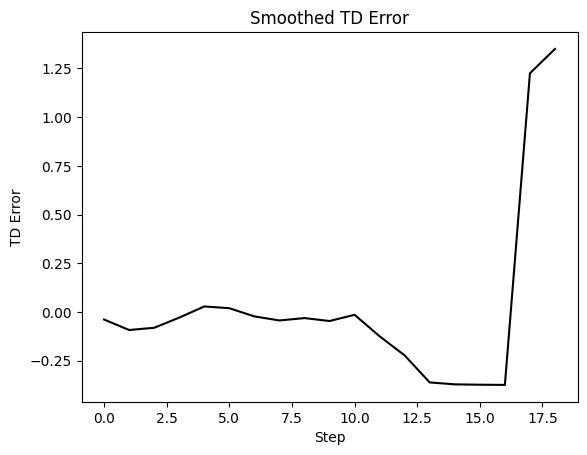

(10, 19)


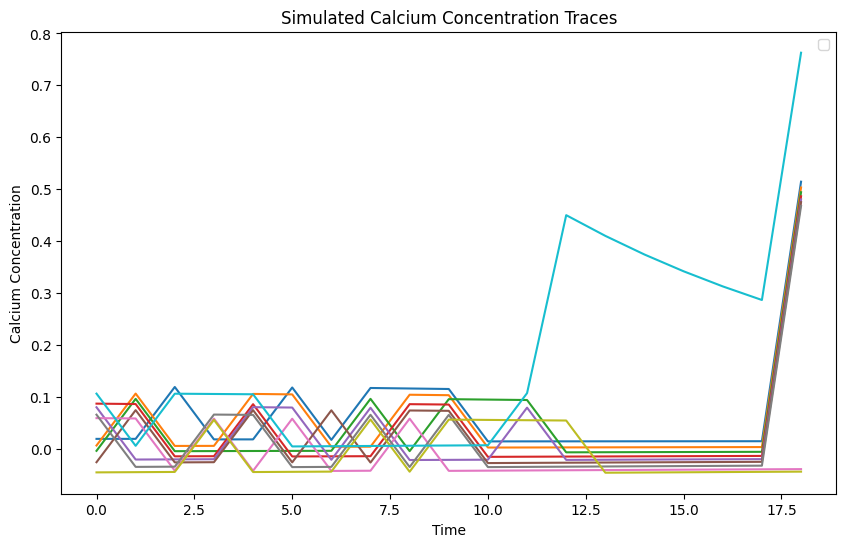

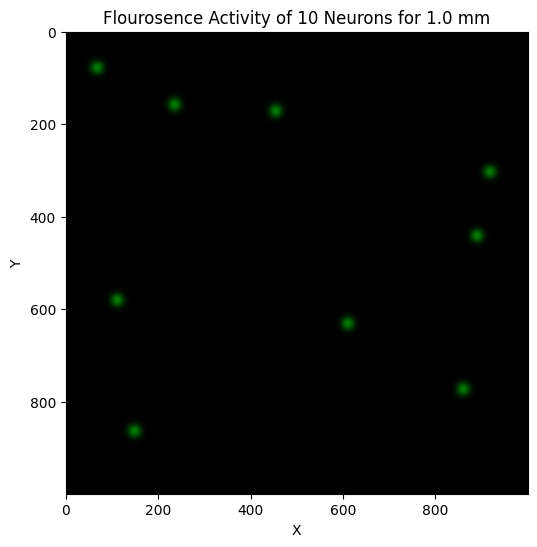

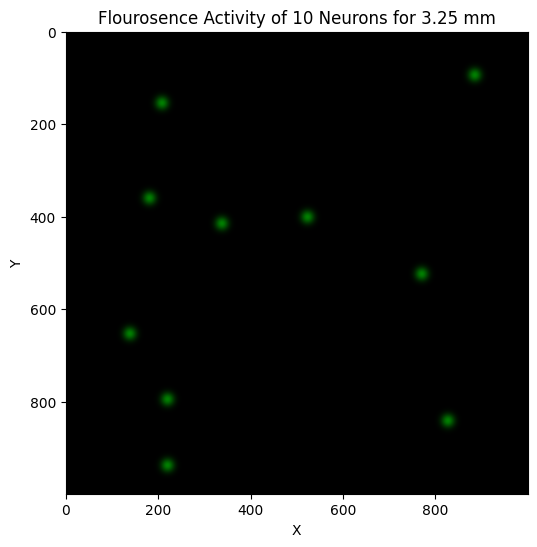

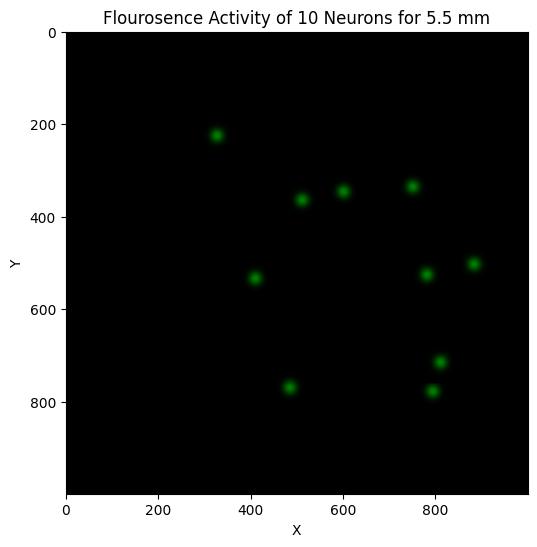

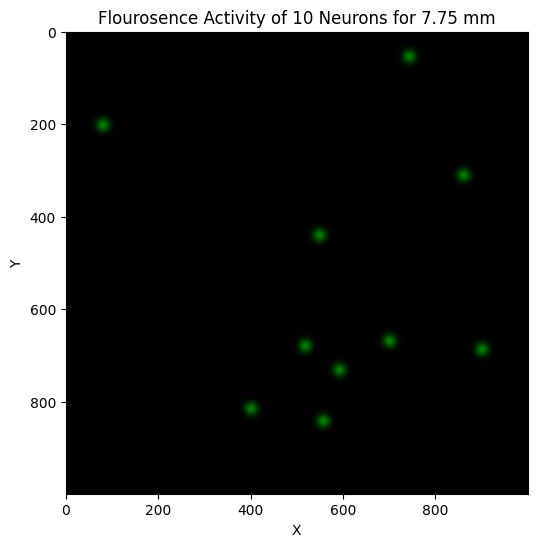

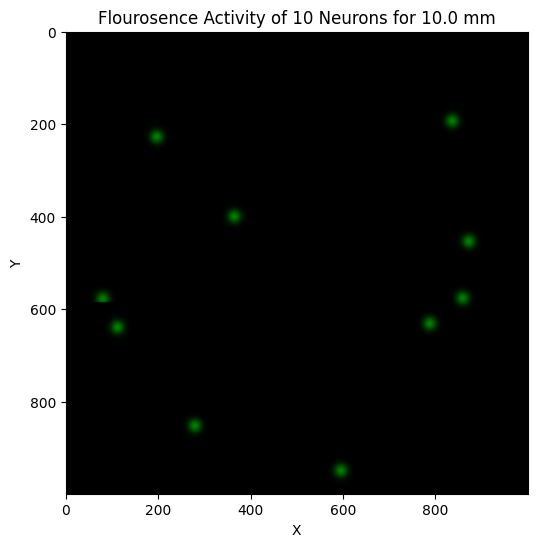

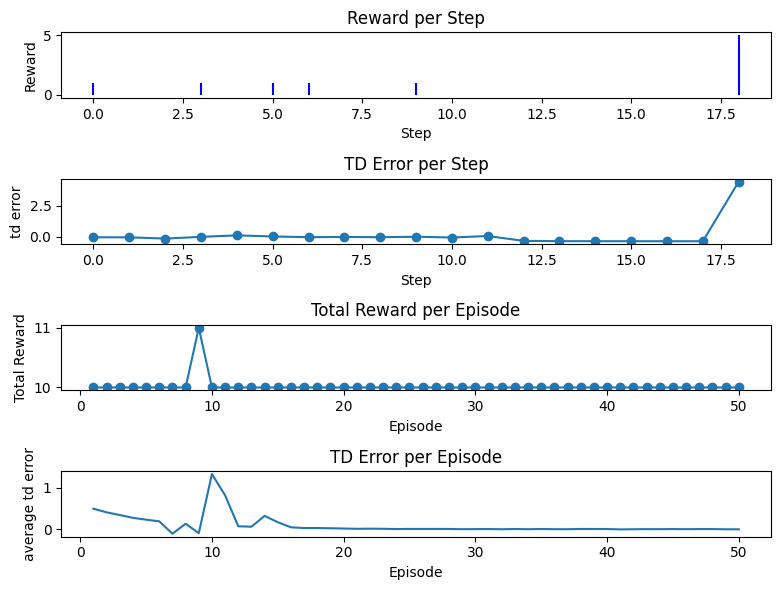

In [ ]:
# Example usage
n_cues_left = 5
n_cues_right = 0
run_episodes(n_cues_left, n_cues_right)

##Simulating movement noise and adding a correction method

Motion artifacts in calcium imaging occur due to animal movement, surgical procedures, brain pulsations, and external factors. These artifacts can introduce distortions and degrade the quality of the imaging data, making it challenging to analyze accurately. To address this, motion correction methods are used to align frames and correct for motion-related distortions

Below we have introduced displacemnet in imaging the calcium signals to simualte the artefacts and have also employed motion correction techniques

Code for adding noise(because its not really evident in the image)

           #ADDING MOVEMENT NOISE#######
          translation_x = np.random.randint(-5, 5)
          translation_y = np.random.randint(-5, 5)
          shifted_image = np.roll(fluorescence, translation_x, axis=0)
          shifted_image = np.roll(shifted_image, translation_y, axis=1)

And here is the code for the movement correction

          ###DDINF MOVEMENT CORRECTION######
          reference_frame = fluorescence# Choose the first frame as the reference


          # Perform Fourier Transform on the images
          fft_shifted = fftn(shifted_image)
          fft_reference = fftn(reference_frame)

          # Calculate cross-power spectrum
          cross_power = np.conj(fft_reference) * fft_shifted

          # Compute the correlation matrix using inverse Fourier Transform
          correlation = np.abs(ifftn(cross_power))

          # Find the maximum correlation location
          max_idx = np.unravel_index(np.argmax(correlation), correlation.shape)

          # Calculate the translation based on the maximum correlation location
          translation = np.array(max_idx) - np.array(shifted_image.shape) // 2

          # Shift the image using NumPy roll operation
          corrected_frame = np.roll(shifted_image, translation, axis=(0, 1))

          # Place the current neuron distribution in the appropriate location within the combined array
          combined_neuron_distributions[start_row:end_row, start_col:end_col] = neuron_distribution

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation, ImageMagickWriter
import os
import matplotlib.colors as mlp_colors
from IPython.display import HTML,clear_output
from skimage.transform import warp
from scipy.fft import fftn, ifftn

def run_episodes(n_cues_left, n_cues_right):
    Q = np.zeros(2)
    # Define the TD learning parameters
    alpha = 0.1  # Learning rate
    gamma = 0.9  # Discount factor
    epsilon = 0.7  # Epsilon for epsilon-greedy strategy
    decay_rate=0.9

    # Initialize the variables for storing the average TD error for each step
    num_steps = 18  # Assuming a corridor length of 13 steps
    num_episodes = 50  # Set the number of episodes
    avg_td_errors = np.zeros(num_steps)
    td_errors1 = []
    td_error = 0#it will have memory of all previous td error s this makes sense
    tderror_tracker = np.zeros((19, num_episodes))
    reward = 0#essentially it has memory of all previous rewards.change this to have memory of rewards from the last 5 episodes
    reward_t1 = []
    action_history1 = []
    action=0
    total_rewards=[]
    td_error = 0
    # Other code...

    for episode in range(num_episodes):
        # Reset the environment and set the rat at position (14, 7)
        observation = env.reset(rat=(14, 7), n_cues_left=n_cues_left, n_cues_right=n_cues_right)
        done = False
        row = 14
        col = 7
        step = 0  # Track the step number


        reward_t1 = []
        td_errors1 = []
        episode_action_history = []  # Action history for the current episode
        total_reward=0
        while not done:
            # env.render()
            #print("step", step)
            # Check if the agent is at the decision-making state
            if row == 2 and col == 7:
                state = 0  # Map the decision-making state to state 0
                action = epsilon_greedy(Q, epsilon)  # Choose the action using epsilon-greedy strategy
                episode_action_history.append(action)  # Append action to the episode action history
            else:
                td_error = reward + gamma * np.max(Q) - Q[action - 1]
                reward = reward
            observation, row, col, reward, done = env.step(action)  # Take a step in the environment

            #print("Row:", row, "Col:", col, "Reward:", reward, "action", action, "td_error", td_error)

            td_error = reward + gamma * np.max(Q) - Q[action - 1]  # Calculate the TD error
            Q[action - 1] += alpha * td_error  # Update the Q-value for the current action


            td_errors1.append(td_error)  # Append the TD error to the list
            reward_t1.append(reward)
            action_history1.append(episode_action_history)
            rd_error = 0
            reward = 0
            step+=1
            # Increment the step count and accumulate the TD error for the corresponding step
            # Assuming the corridor is between rows 2 and 14

            # avg_td_errors[step - 1] += (td_error - avg_td_errors[step - 1])
            #print(Q)
        tderror_tracker[:len(td_errors1), episode] = np.array(td_errors1[:19])
        total_rewards.append(sum(reward_t1))
        epsilon*=decay_rate

    #print(tderror_tracker)

    # Calculate the average TD error for each step


    # Calculate the average TD error for each step
    avg_td_errors = np.mean(tderror_tracker, axis=1)  # TD error per step
    avg_error_per_episode = np.mean(tderror_tracker, axis=0)  # TD error per episode
    print("TOTAL REWARD", np.sum(avg_error_per_episode))

    # Smooth the TD error data using a moving average
    window_size = 3  # Adjust the window size as desired
    smoothed_td_errors = np.convolve(avg_td_errors, np.ones(window_size)/window_size, mode='same')

    # Plot the smoothed TD error data
    plt.plot(range(len(avg_td_errors)), smoothed_td_errors, '-k')

    plt.xlabel('Step')
    plt.ylabel('TD Error')
    plt.title('Smoothed TD Error')
    plt.show()



    noise_level=0.1
    num_neurons = tderror_tracker.shape[0]
    gcamp_kernel = np.random.rand(num_neurons)
    fluorescence_episode = []
    delta_fluorescence_traces=[1]
    total_fluorescence_traces=[]
    ratio=[]

    delta_fluorescence_traces = []
    total_fluorescence_traces = []
    time=tderror_tracker.shape[1]



    # AR Model Parameters
    #SIMULATING CALCIUM ACTIVITTY
    p = 1  # Order of the AR model
    gamma = np.linspace(0.1, 0.4, p)#the ar coeffiecient
    C_dt = 0.1
    nc = C_dt / time
    num_neurons=10
    calcium_concentration_traces = []
    calcium_concentration_matrix = []

    for i in range(num_neurons):
      for t in range(time):

        spikes = tderror_tracker[:, t]

        calcium_concentration = np.convolve(gamma, spikes) + np.sum(spikes) * nc


        calcium_concentration_traces.append(calcium_concentration)
      calcium_concentration_matrix.append(calcium_concentration)
    calc_array = np.array(calcium_concentration_matrix)
    print(calc_array.shape)
    sum_calc=np.sum(calc_array,axis=1)
    # Plot the calcium concentration traces
    plt.figure(figsize=(10, 6))
    for i in range(10):
        calcium_trace = calcium_concentration_traces[i]
        plt.plot(calcium_trace)

    plt.xlabel('Time')
    plt.ylabel('Calcium Concentration')
    plt.title('Simulated Calcium Concentration Traces')
    plt.legend()
    plt.show()

   ##SIMULATING and plotting THE FLOUROSCENT ACTIVITY

    baseline = np.random.rand(time)  # Time-dependent baseline
    noise_mean = 0  # Mean of the Gaussian noise
    noise_std = 0.1  # Standard deviation of the Gaussian noise
    num_neurons = 10
    Neu_locs = np.random.rand(num_neurons, 2)  # Random neuron locations in 2D space
    NeuSize = 2  # Average size of neurons

    # Generate 2D Gaussian distribution for each neuron
    x, y = np.meshgrid(np.linspace(-10, 10, 100), np.linspace(-10, 10, 100))  # Grid of x and y coordinates

    combined_neuron_distributions = np.zeros((100 * num_neurons, 100 * num_neurons))  # Initialize combined neuron distribution array
    fluorescence_image = np.zeros_like(combined_neuron_distributions)

    fluorescence_array=[]
    fluorescence_cmap = mlp_colors.LinearSegmentedColormap.from_list('GreenToBlack', ['black', 'green'],N=256)
    fluorescence_norm = mlp_colors.Normalize(vmin=0, vmax=np.max(fluorescence_image))

    #########THE INDICATOR PROPERTIES#######
    # Define indicator parameters as vectors of 10 uniformly distributed values
    quantum_yield = np.linspace(20, 70, 5)#in percent
    molar_extinction_coefficient = np.linspace(5000, 15000, 5)
    concentration = np.linspace(1.0, 10.0, 5)
    excitation_intensity = np.linspace(100.0, 1000.0, 5)
    fluorescenct_image = np.zeros((100 * num_neurons, 100 * num_neurons))
    fluorescence_image = np.zeros((100 * num_neurons, 100 * num_neurons))
    combined_neuron_distributions=np.zeros((100 * num_neurons, 100 * num_neurons))
    fluorescences_image=np.zeros((100 * num_neurons, 100 * num_neurons))
    for i in range(num_neurons):
          sigma = NeuSize  # Random sigma from a normal distribution
          neuron_distribution = np.exp(-((x - Neu_locs[i, 0]) ** 2 + (y - Neu_locs[i, 1]) ** 2) / (2 * sigma ** 2))#the a(i)   or the spatial extent 3of  aneuron
          neuron_calc_activity=sum_calc[i]

          fluorescence_per_neuron = np.multiply(neuron_distribution, neuron_calc_activity)+ baseline[t]+np.random.normal(noise_mean, noise_std, size=neuron_distribution.shape)
          fluorescence=np.exp(-((x - fluorescence_per_neuron[i, 0]) ** 2 + (y - fluorescence_per_neuron[i, 1]) ** 2) / (2 * sigma ** 2))

          #ADDING MOVEMENT NOISE#######
          translation_x = np.random.randint(-50, 50)
          translation_y = np.random.randint(-50, 50)
          shifted_image = np.roll(fluorescence, translation_x, axis=0)
          shifted_image = np.roll(shifted_image, translation_y, axis=1)

        # Calculate the indices for placing the current neuron distribution in the combined array
          start_row = np.random.randint(0, 100 * num_neurons - 100)
          end_row = start_row + 100
          start_col = np.random.randint(0, 100 * num_neurons - 100)
          end_col = start_col + 100

          ###DDINF MOVEMENT CORRECTION######
          reference_frame = fluorescence# Choose the first frame as the reference


          # Perform Fourier Transform on the images
          fft_shifted = fftn(shifted_image)
          fft_reference = fftn(reference_frame)

          # Calculate cross-power spectrum
          cross_power = np.conj(fft_reference) * fft_shifted

          # Compute the correlation matrix using inverse Fourier Transform
          correlation = np.abs(ifftn(cross_power))

          # Find the maximum correlation location
          max_idx = np.unravel_index(np.argmax(correlation), correlation.shape)

          # Calculate the translation based on the maximum correlation location
          translation = np.array(max_idx) - np.array(shifted_image.shape) // 2

          # Shift the image using NumPy roll operation
          corrected_frame = np.roll(shifted_image, translation, axis=(0, 1))

          # Place the current neuron distribution in the appropriate location within the combined array
          combined_neuron_distributions[start_row:end_row, start_col:end_col] = neuron_distribution
          fluorescence_image[start_row:end_row, start_col:end_col] = shifted_image
          fluorescenct_image[start_row:end_row, start_col:end_col] = fluorescence
          fluorescences_image[start_row:end_row, start_col:end_col] = corrected_frame
          fluorescence_array.append(fluorescence_image)
          #fluorescences_array.append(corrected_frame)


    plt.figure(figsize=(10, 6))
    plt.imshow(fluorescenct_image,fluorescence_cmap)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'Flourosence Activity of {num_neurons} neurons without movement artefacts')

    plt.figure(figsize=(10, 6))
    plt.imshow(fluorescence_image,fluorescence_cmap)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'Flourosence Activity of {num_neurons} neurons with movement artefacts')



    plt.figure(figsize=(10, 6))
    plt.imshow(fluorescences_image,fluorescence_cmap)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'Flourosence Activity of {num_neurons} neurons withcorrected movement artefacts')
      #plt.title(f'Flourosence Activity of {num_neurons} Neurons for {concentration[j]} ')
      #plt.title(f'Flourosence Activity of {num_neurons} Neurons for {quantum_yield[j]} ')
      #plt.title(f'Flourosence Activity of {num_neurons} Neurons for {molar_extinction_coefficient[j]} ')
      #plt.title(f'Flourosence Activity of {num_neurons} Neurons for {excitation_intensity[j]} ')



    """

    fluorescence_combined_array=[]
    combined_fl_distributions=np.zeros((100 * num_neurons, 100 * num_neurons))
    neu_deu=[]







    for i in range(num_neurons):
      sigma = NeuSize  # Random sigma from a normal distribution
      neuron_distribution = np.exp(-((x - Neu_locs[i, 0]) ** 2 + (y - Neu_locs[i, 1]) ** 2) / (2 * sigma ** 2))#the a(i)   or the spatial extent 3of  aneuron
      neu_deu.append(neuron_distribution)
    for t in range(int(time)):

      combined_fl_distributions = np.zeros((100 * num_neurons, 100 * num_neurons))  # Create a new array for each time step
      for i in range(num_neurons):
         sigma=NeuSize
         neuron_calc_activity=sum_calc[i]
         fluorescence_per_neuron_per_unit_time = np.multiply(neu_deu[i], neuron_calc_activity)+ baseline[t]+np.random.normal(noise_mean, noise_std, size=neu_deu[i].shape)
         fluorescence_distribution_per_neuron_per_unit_time=np.exp(-((x - fluorescence_per_neuron_per_unit_time[i, 0]) ** 2 + (y - fluorescence_per_neuron_per_unit_time[i, 1]) ** 2) / (2 * sigma ** 2))
         # Calculate the indices for placing the current neuron distribution in the combined array
         start_row = np.random.randint(0, 100 * num_neurons - 100)
         end_row = start_row + 100
         start_col = np.random.randint(0, 100 * num_neurons - 100)
         end_col = start_col + 100
         # Place the current neuron distribution in the appropriate location within the combined array
         combined_fl_distributions[start_row:end_row, start_col:end_col] = fluorescence_distribution_per_neuron_per_unit_time

      fluorescence_combined_array.append(combined_fl_distributions)
    # Plot the combined neuron distributions
    plt.figure(figsize=(10, 6))
    plt.imshow(combined_neuron_distributions, cmap='gray')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'Calcium Activity of {num_neurons} Neurons')

    plt.show()

    plt.figure(figsize=(10, 6))
    plt.imshow(fluorescence_image,fluorescence_cmap)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'Flourosence Activity of {num_neurons} Neurons')

    plt.show()

    frames = [] # for storing the generated images
    fig = plt.figure()

    for i in range(len(fluorescence_combined_array)):
        frames.append([plt.imshow(fluorescence_combined_array[i], fluorescence_cmap,animated=True)])

    ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True,
                                    repeat_delay=1000)
    ani.save('/content/fluorescence_animation.mp4')
    from IPython.display import Video

    video_path = '/content/fluorescence_animation.mp4'  # Path to your saved video file
    from IPython.display import HTML
    from base64 import b64encode

    def show_video(video_path, video_width = 600):

      video_file = open(video_path, "r+b").read()

      video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"


    show_video(video_path)
    """

















    # Create a figure with two subplots
    fig, (ax1, ax2,ax3,ax4) = plt.subplots(4, 1, figsize=(8, 6))

    # Plot the reward per step
    stepss = range(len(reward_t1))
    ax1.vlines(stepss, [0], reward_t1, colors='blue')
    ax1.set_xlabel('Step')
    ax1.set_ylabel('Reward')
    ax1.set_title('Reward per Step')

    # Plot the TD error per step

    ax2.plot(range(len(avg_td_errors)), avg_td_errors, marker='o', linestyle='-')
    ax2.set_xlabel('Step')
    ax2.set_ylabel('td error')
    ax2.set_title('TD Error per Step')


        # Plot the total reward per episode
    episodes = range(1, num_episodes + 1)
    ax3.plot(episodes, total_rewards, marker='o', linestyle='-')
    ax3.set_xlabel('Episode')
    ax3.set_ylabel('Total Reward')
    ax3.set_title('Total Reward per Episode')

            # Plot the avg td error per episode
    episodes = range(1, num_episodes + 1)
    ax4.plot(episodes, avg_error_per_episode, linestyle='-')
    ax4.set_xlabel('Episode')
    ax4.set_ylabel('average td error')
    ax4.set_title('TD Error per Episode')

    # Adjust the layout to prevent overlapping of subplots
    plt.tight_layout()

    # Display the plot
    plt.show()









TOTAL REWARD 5.2759619939110305


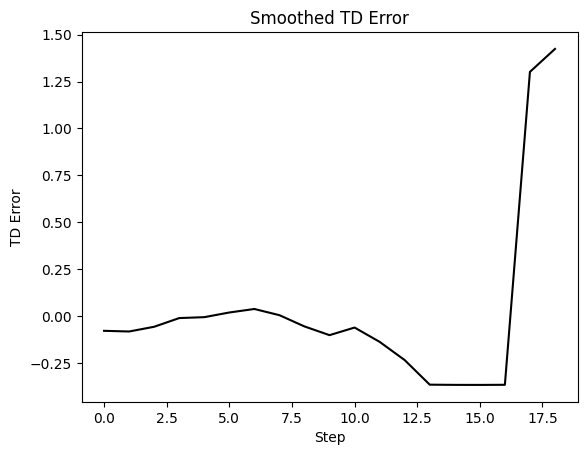

(10, 19)


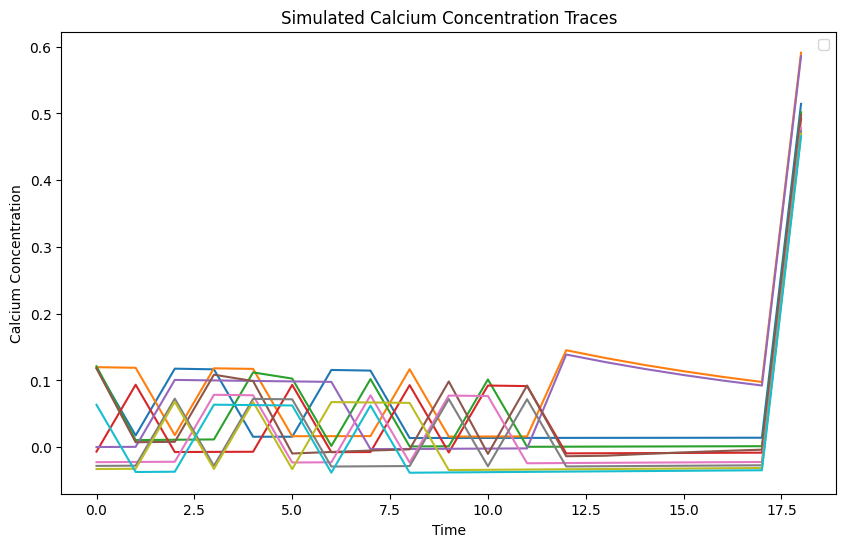

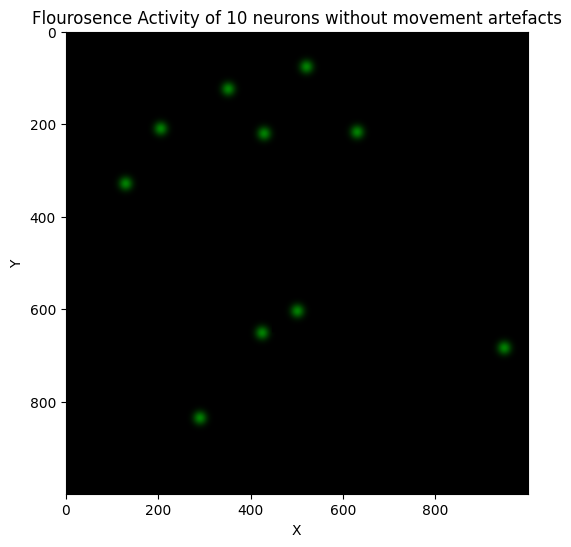

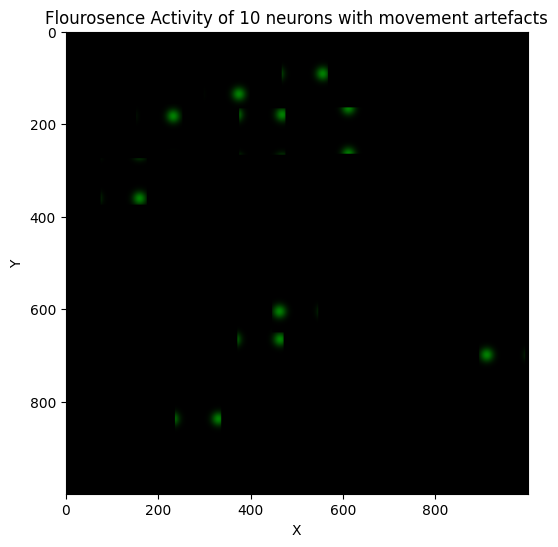

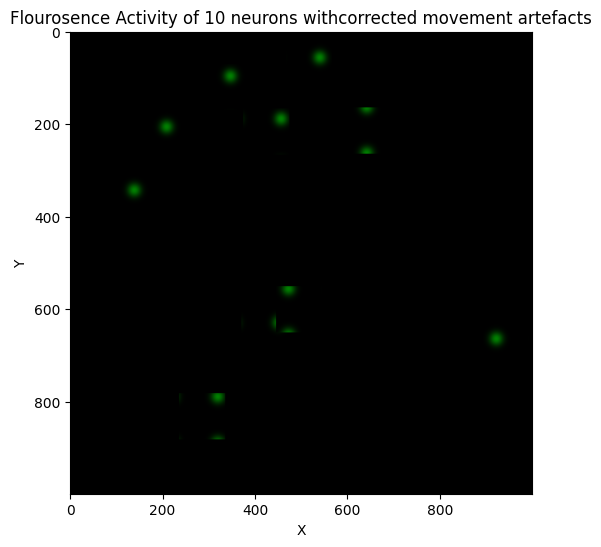

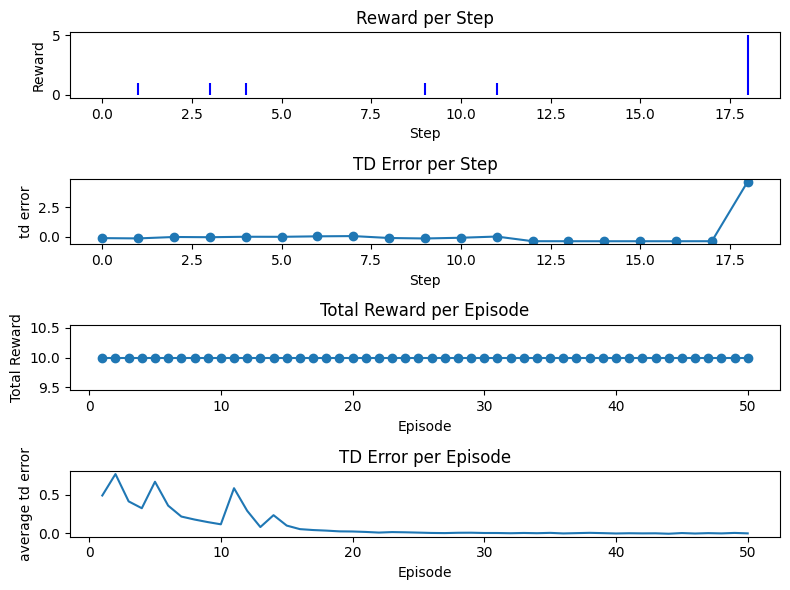

In [ ]:
# Example usage
n_cues_left = 5
n_cues_right = 0
run_episodes(n_cues_left, n_cues_right)